In [1]:
import pandas as pd
import numpy as np
from calendar import day_name
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from collections import Counter
from astroML.density_estimation import EmpiricalDistribution
from scipy.optimize import NonlinearConstraint, Bounds, differential_evolution
from IPython.display import clear_output
from scipy.optimize import minimize
import traceback
import matplotlib.font_manager
import os

# Preprocessing and Feature Extraction

## Old data

In [2]:
%%time
folder=r'data.csv'
data = pd.read_csv(folder, parse_dates=['date'], encoding='utf-8')
data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()
data

CPU times: user 719 ms, sys: 140 ms, total: 859 ms
Wall time: 1.11 s


,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday
2,2021-04-14,1,91.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.650000,2,Wednesday
3,2021-04-15,1,73.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.521429,3,Thursday
4,2021-04-16,1,48.0,2510.0,001А,Купе,001А-Купе,23.916667,7.916667,0.342857,4,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
413037,2021-07-16,89,368.0,3200.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,4,Friday
413038,2021-07-17,89,361.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.975676,5,Saturday
413039,2021-07-19,89,362.0,2800.0,780А,C2,780А-C2,21.000000,0.583333,0.978378,0,Monday
413040,2021-07-22,89,368.0,2660.0,780А,C2,780А-C2,21.000000,0.583333,0.994595,3,Thursday


## New data

In [4]:
%%time

folder='new_data.csv'

new_data = pd.read_csv(folder, parse_dates=['date'], index_col=[0], encoding='utf-8')

new_data['weekday'] = new_data['date'].dt.weekday
new_data['day_name'] = new_data['date'].dt.day_name()
new_data

CPU times: user 1.66 s, sys: 393 ms, total: 2.06 s
Wall time: 2.56 s


,days,date,num,departure_hour,arrival_hour,class,price,places,train,weekday,day_name
0,1,2021-06-02,002А,7.55,23.55,Купе,4682.0,66.0,002А-Купе,2,Wednesday
1,1,2021-06-02,006А,6.30,22.50,СВ,4655.0,15.0,006А-СВ,2,Wednesday
2,1,2021-06-02,780А,0.35,21.00,C1,7910.0,3.0,780А-C1,2,Wednesday
3,1,2021-06-02,780А,0.35,21.00,B2,3990.0,14.0,780А-B2,2,Wednesday
4,1,2021-06-02,780А,0.35,21.00,C2,3486.0,145.0,780А-C2,2,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
1119931,89,2022-01-28,701Н,11.37,7.45,СВ,3962.0,42.0,701Н-СВ,4,Friday
1119932,89,2022-01-28,701Н,11.37,7.45,Сидячий,1333.0,351.0,701Н-Сидячий,4,Friday
1119933,89,2022-01-28,775А,1.03,17.00,B1,20851.3,15.0,775А-B1,4,Friday
1119934,89,2022-01-28,775А,1.03,17.00,C1,9503.3,20.0,775А-C1,4,Friday


## All data

In [ ]:
data=pd.concat([data, new_data.query('date>"2021-07-23"')], ignore_index=True)
weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

## Demand and prices

In [ ]:
uniq_train_names=data['train'].unique()
uniq_train_num=data['num'].unique()
wk_days_mask=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
places = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='places')
train_name='752А'
wk_day='Friday'
places.loc[train_name].loc['Friday', :14].head()
print(data.date.min())
print(data.date.max())

In [6]:
%%time
demand=(places-places.shift(axis=1))
demand[demand<0.]=np.nan
demand=demand.drop(columns=1, axis=0)
prices = data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='price')
prices_cons=prices.copy()
prices=prices.drop(columns=1, axis=0)
demand.loc[train_name].loc[wk_day, :14].head()

CPU times: user 874 ms, sys: 78.3 ms, total: 953 ms
Wall time: 935 ms


days                2     3     4     5     6    7     8     9    10   11  \
date       class                                                            
2021-04-16 B1      4.0   2.0   0.0   2.0   0.0  0.0   3.0   2.0  0.0  0.0   
           B2     16.0  16.0   4.0   0.0   0.0  2.0   2.0   0.0  2.0  0.0   
           C1      9.0   4.0   0.0   0.0   0.0  1.0   2.0   0.0  1.0  0.0   
           C2     79.0  49.0  33.0  22.0  19.0  5.0  21.0  22.0  9.0  2.0   
2021-04-23 B1      0.0   NaN   NaN   0.0   0.0  2.0   0.0   1.0  0.0  NaN   

days               12   13   14  
date       class                 
2021-04-16 B1     0.0  0.0  0.0  
           B2     0.0  1.0  2.0  
           C1     0.0  0.0  1.0  
           C2     8.0  5.0  9.0  
2021-04-23 B1     0.0  0.0  1.0

In [7]:
def scatter_plot(sliced_x: pd.DataFrame, sliced_y: pd.DataFrame, days: np.array, fig_name: str):
    
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(31, 22)
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    
    for ax in axes.flat[len(days):]:
        ax.set_visible(False)
    for day, ax in zip(days, axes.flatten()):
        ax.scatter(sliced_x[day], sliced_y[day])
        ax.set_ylabel('Demand')
        ax.set_xlabel('Price')
        ax.set_title(train_name+', '+ str(day) + ' days before departure'+' ('+wk_day+'s) ')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid()
        
    #plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

CPU times: user 449 ms, sys: 15.8 ms, total: 465 ms
Wall time: 617 ms


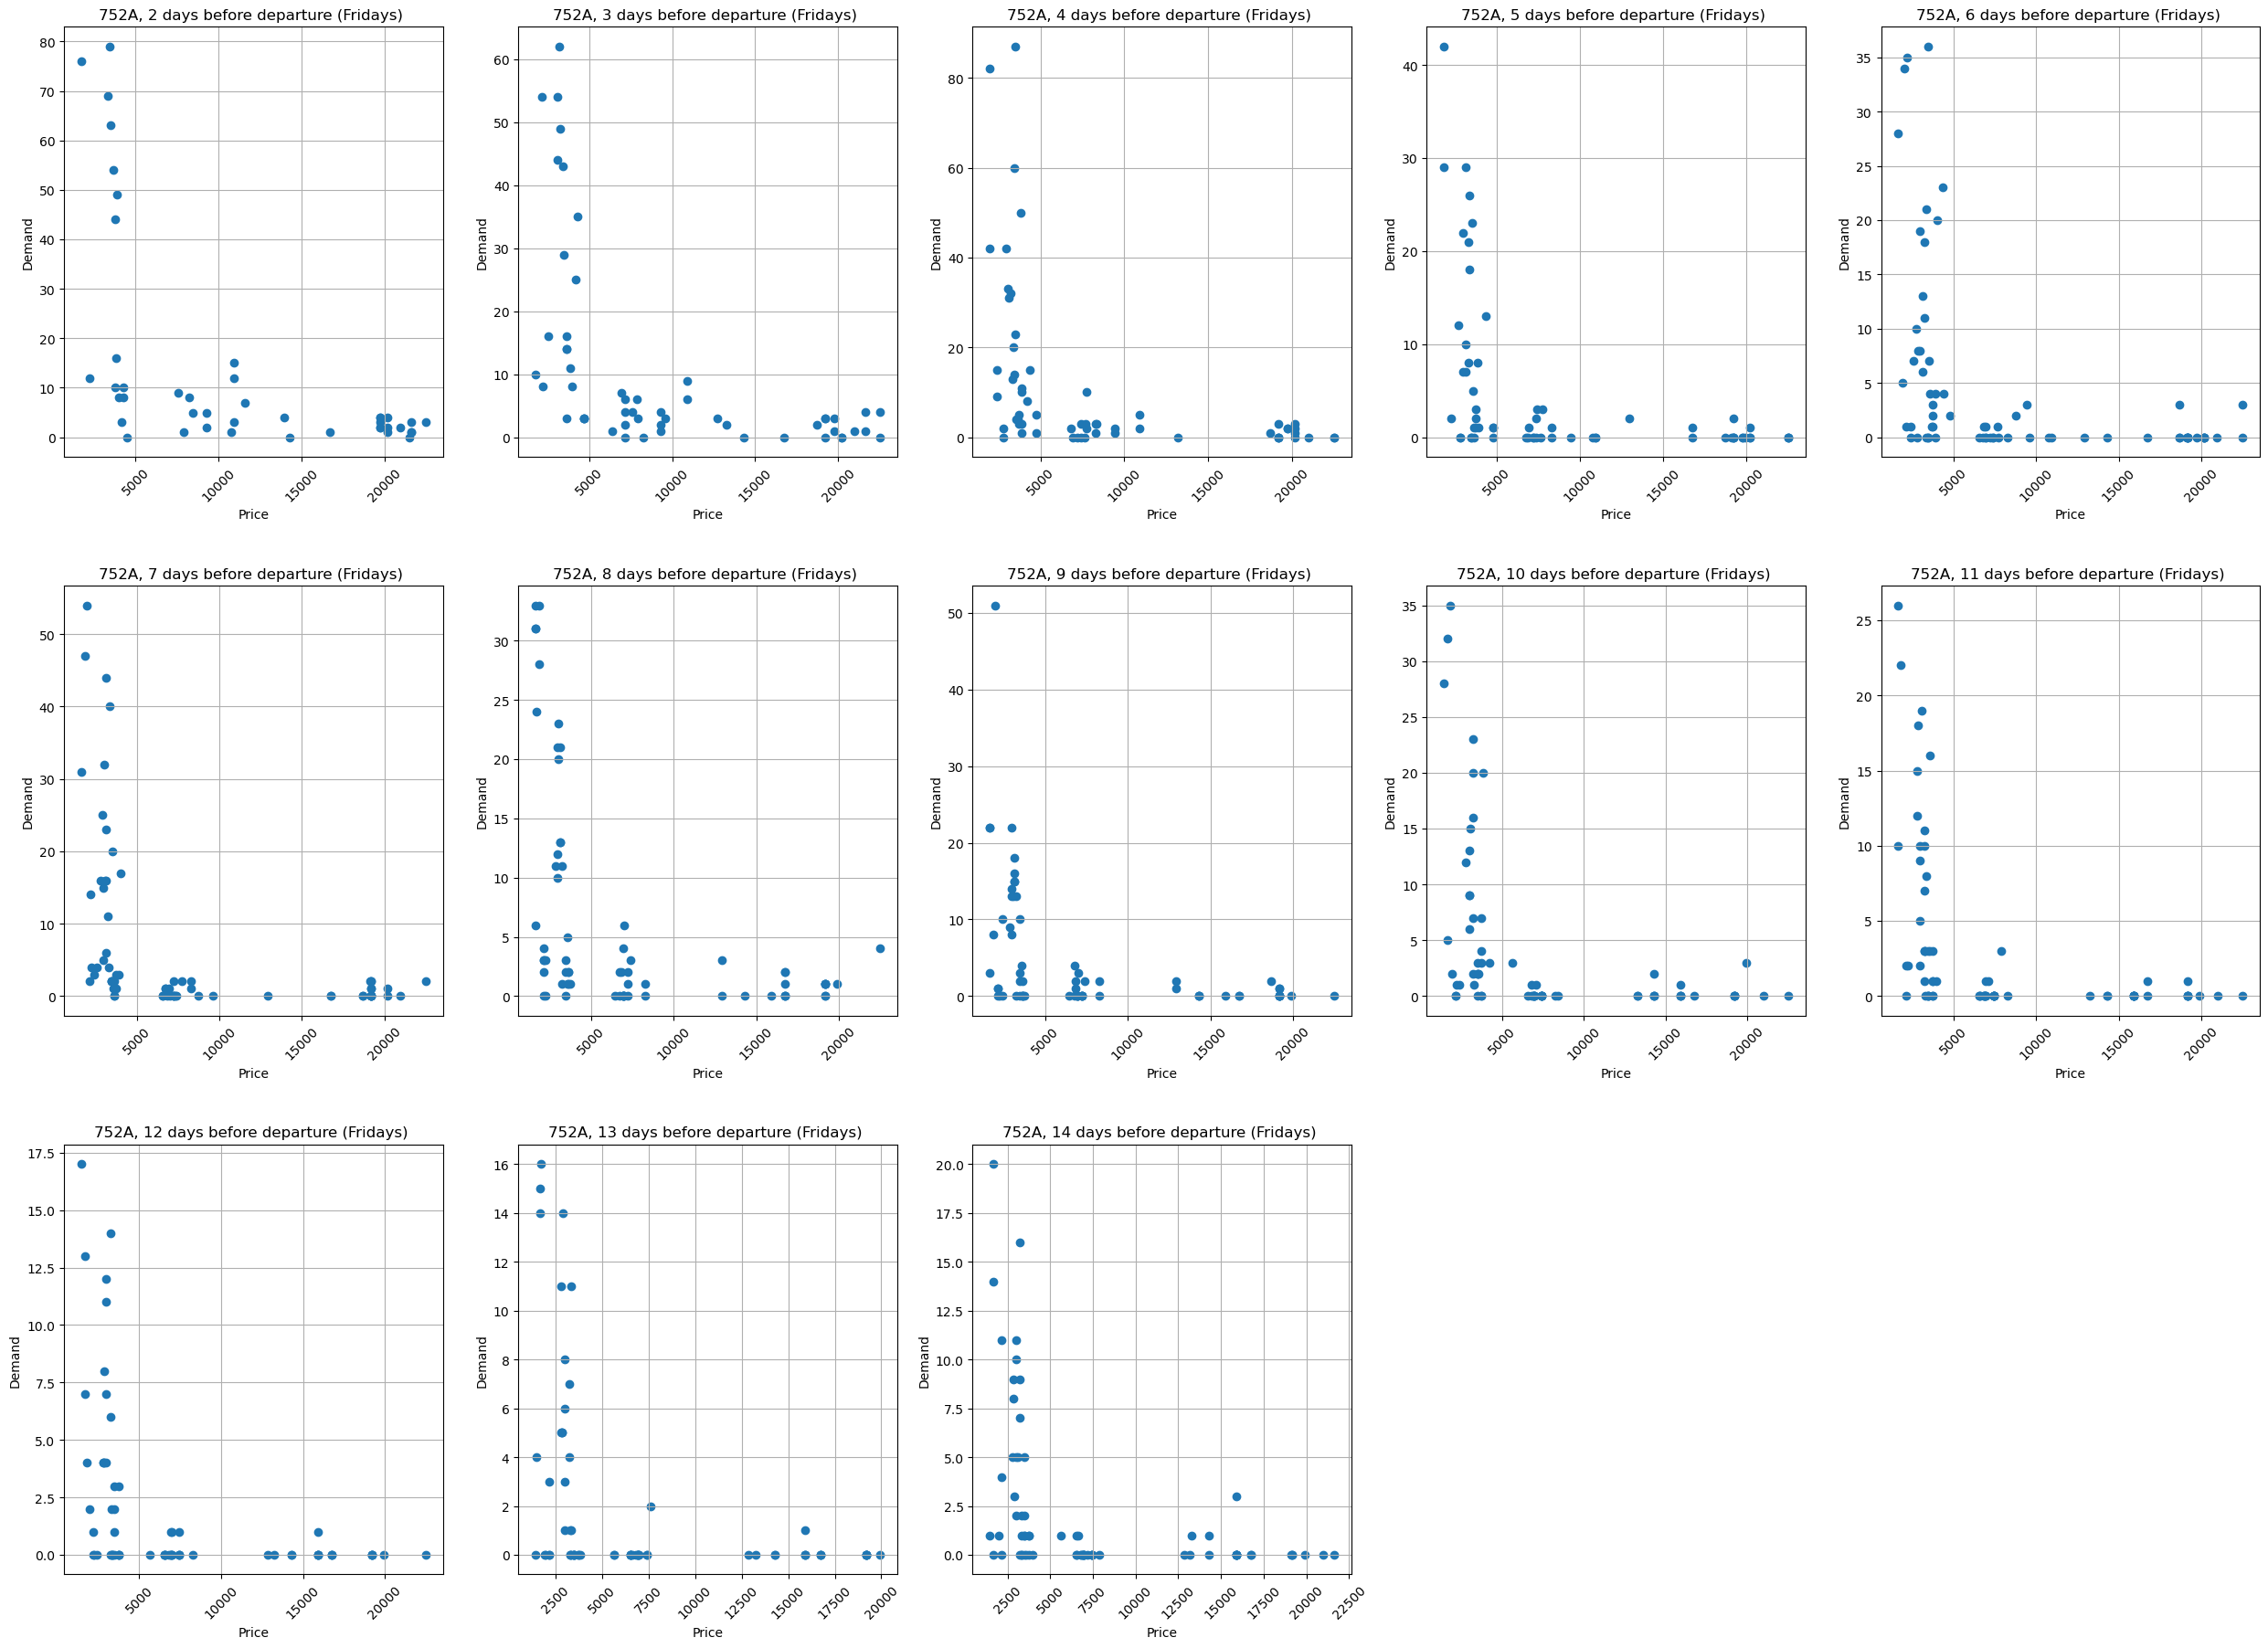

In [8]:
%%time
days=np.arange(2, 15)    
scatter_plot(prices.loc[train_name].loc[wk_day], demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'no cleaned')

## Removing duplicates and averaging

In [9]:
def mean_duplicate_prices(sliced_data: pd.Series, sliced_tardet: pd.Series)->pd.DataFrame:
    
    '''The function accepts slices by price and demand, for a certain train, 
    day of the week and day before departure, the output is a pivot table in
    which demand values are averaged for which prices are the same. The class 
    and date columns store all classes and dates for which the average was performed.'''
    
    df=pd.DataFrame(data=np.array([sliced_data.values, sliced_tardet.values]).T, 
                    columns=['prices', 'demand'], index=sliced_data.index, dtype=object).reset_index()
    
    if len(df['prices'].dropna())==0:
        
        piv=df
        
    else:
        
        piv=df.pivot_table(index=['prices'], sort = False, dropna=False, 
                                         values=['demand', 'date', 'class'], 
                                         aggfunc={'demand': np.nanmean, 
                                                  'date': lambda x: x, 
                                                  'class': ','.join}).reset_index()
    return piv

In [10]:
def flat_grouped_classes(pivot_data: pd.DataFrame)->pd.DataFrame:
    
    '''The function takes a pivot table with prices and demand 
    from the mean_duplicate_prices function and straightens the
    class and date groups. The cell with the averaged demand retains 
    the class most frequently encountered during the average and the 
    corresponding date. The rest of the classes and dates are added to
    the end of the frame, with empty price and demand values.'''
    
    for row in pivot_data.T:
        class_row=list(pivot_data['class'][row].split(','))
        date_row=[pivot_data['date'][row]]
        str_date_row=list(pivot_data['date'][row].strftime('%Y-%m-%d'))
    
        if len(class_row)>1:
        
            count_classes=Counter(class_row)
        
            max_val = max(count_classes.values())
            max_class = [k for k, v in count_classes.items() if v == max_val][0]
        
            class_num=[class_num for class_num, 
                   class_name in enumerate(class_row) 
                   if class_name==max_class][0]
        
            pivot_data.loc[pivot_data.index[row], 'class']=max_class
            pivot_data.loc[pivot_data.index[row], 'date']=date_row[0][class_num]
        
            del class_row[class_num], str_date_row[class_num]
        
            for cl, dt in zip(class_row, str_date_row):
                pivot_data=pd.concat([pivot_data, pd.DataFrame([[np.nan, cl, dt,  np.nan]], columns=pivot_data.columns)])
                pivot_data['date']=pivot_data['date'].apply(pd.to_datetime)
                pivot_data.reset_index(drop = True , inplace = True)
    
    return pivot_data

In [11]:
%%time
mean_prices=pd.DataFrame(data=np.nan, columns=prices.columns, index=prices.index, dtype="float")
mean_demand=pd.DataFrame(data=np.nan, columns=demand.columns, index=demand.index, dtype="float")
for num in uniq_train_num:
    for wk_day in wk_days_mask:
        for day in demand.columns:
            pr_dem_piv=mean_duplicate_prices(prices.loc[num].loc[wk_day][day], 
                                             demand.loc[num].loc[wk_day][day])
            
            flat_pr_dem_piv=flat_grouped_classes(pr_dem_piv)
            
            mean_prices.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['prices']
            mean_demand.loc[num, wk_day].T.loc[day]=flat_pr_dem_piv.set_index(['date', 'class'])['demand']

Wall time: 23min 3s


In [12]:
mean_prices.to_csv('All_data\mean_prices.csv')
mean_demand.to_csv('All_data\mean_demand.csv')

In [17]:
mean_p = pd.read_csv(r'All_data/mean_prices.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
mean_p.columns.name='days'
mean_p.columns=mean_p.columns.astype(int)
mean_d = pd.read_csv(r'All_data/mean_demand.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
mean_d.columns.name='days'
mean_d.columns=mean_d.columns.astype(int)

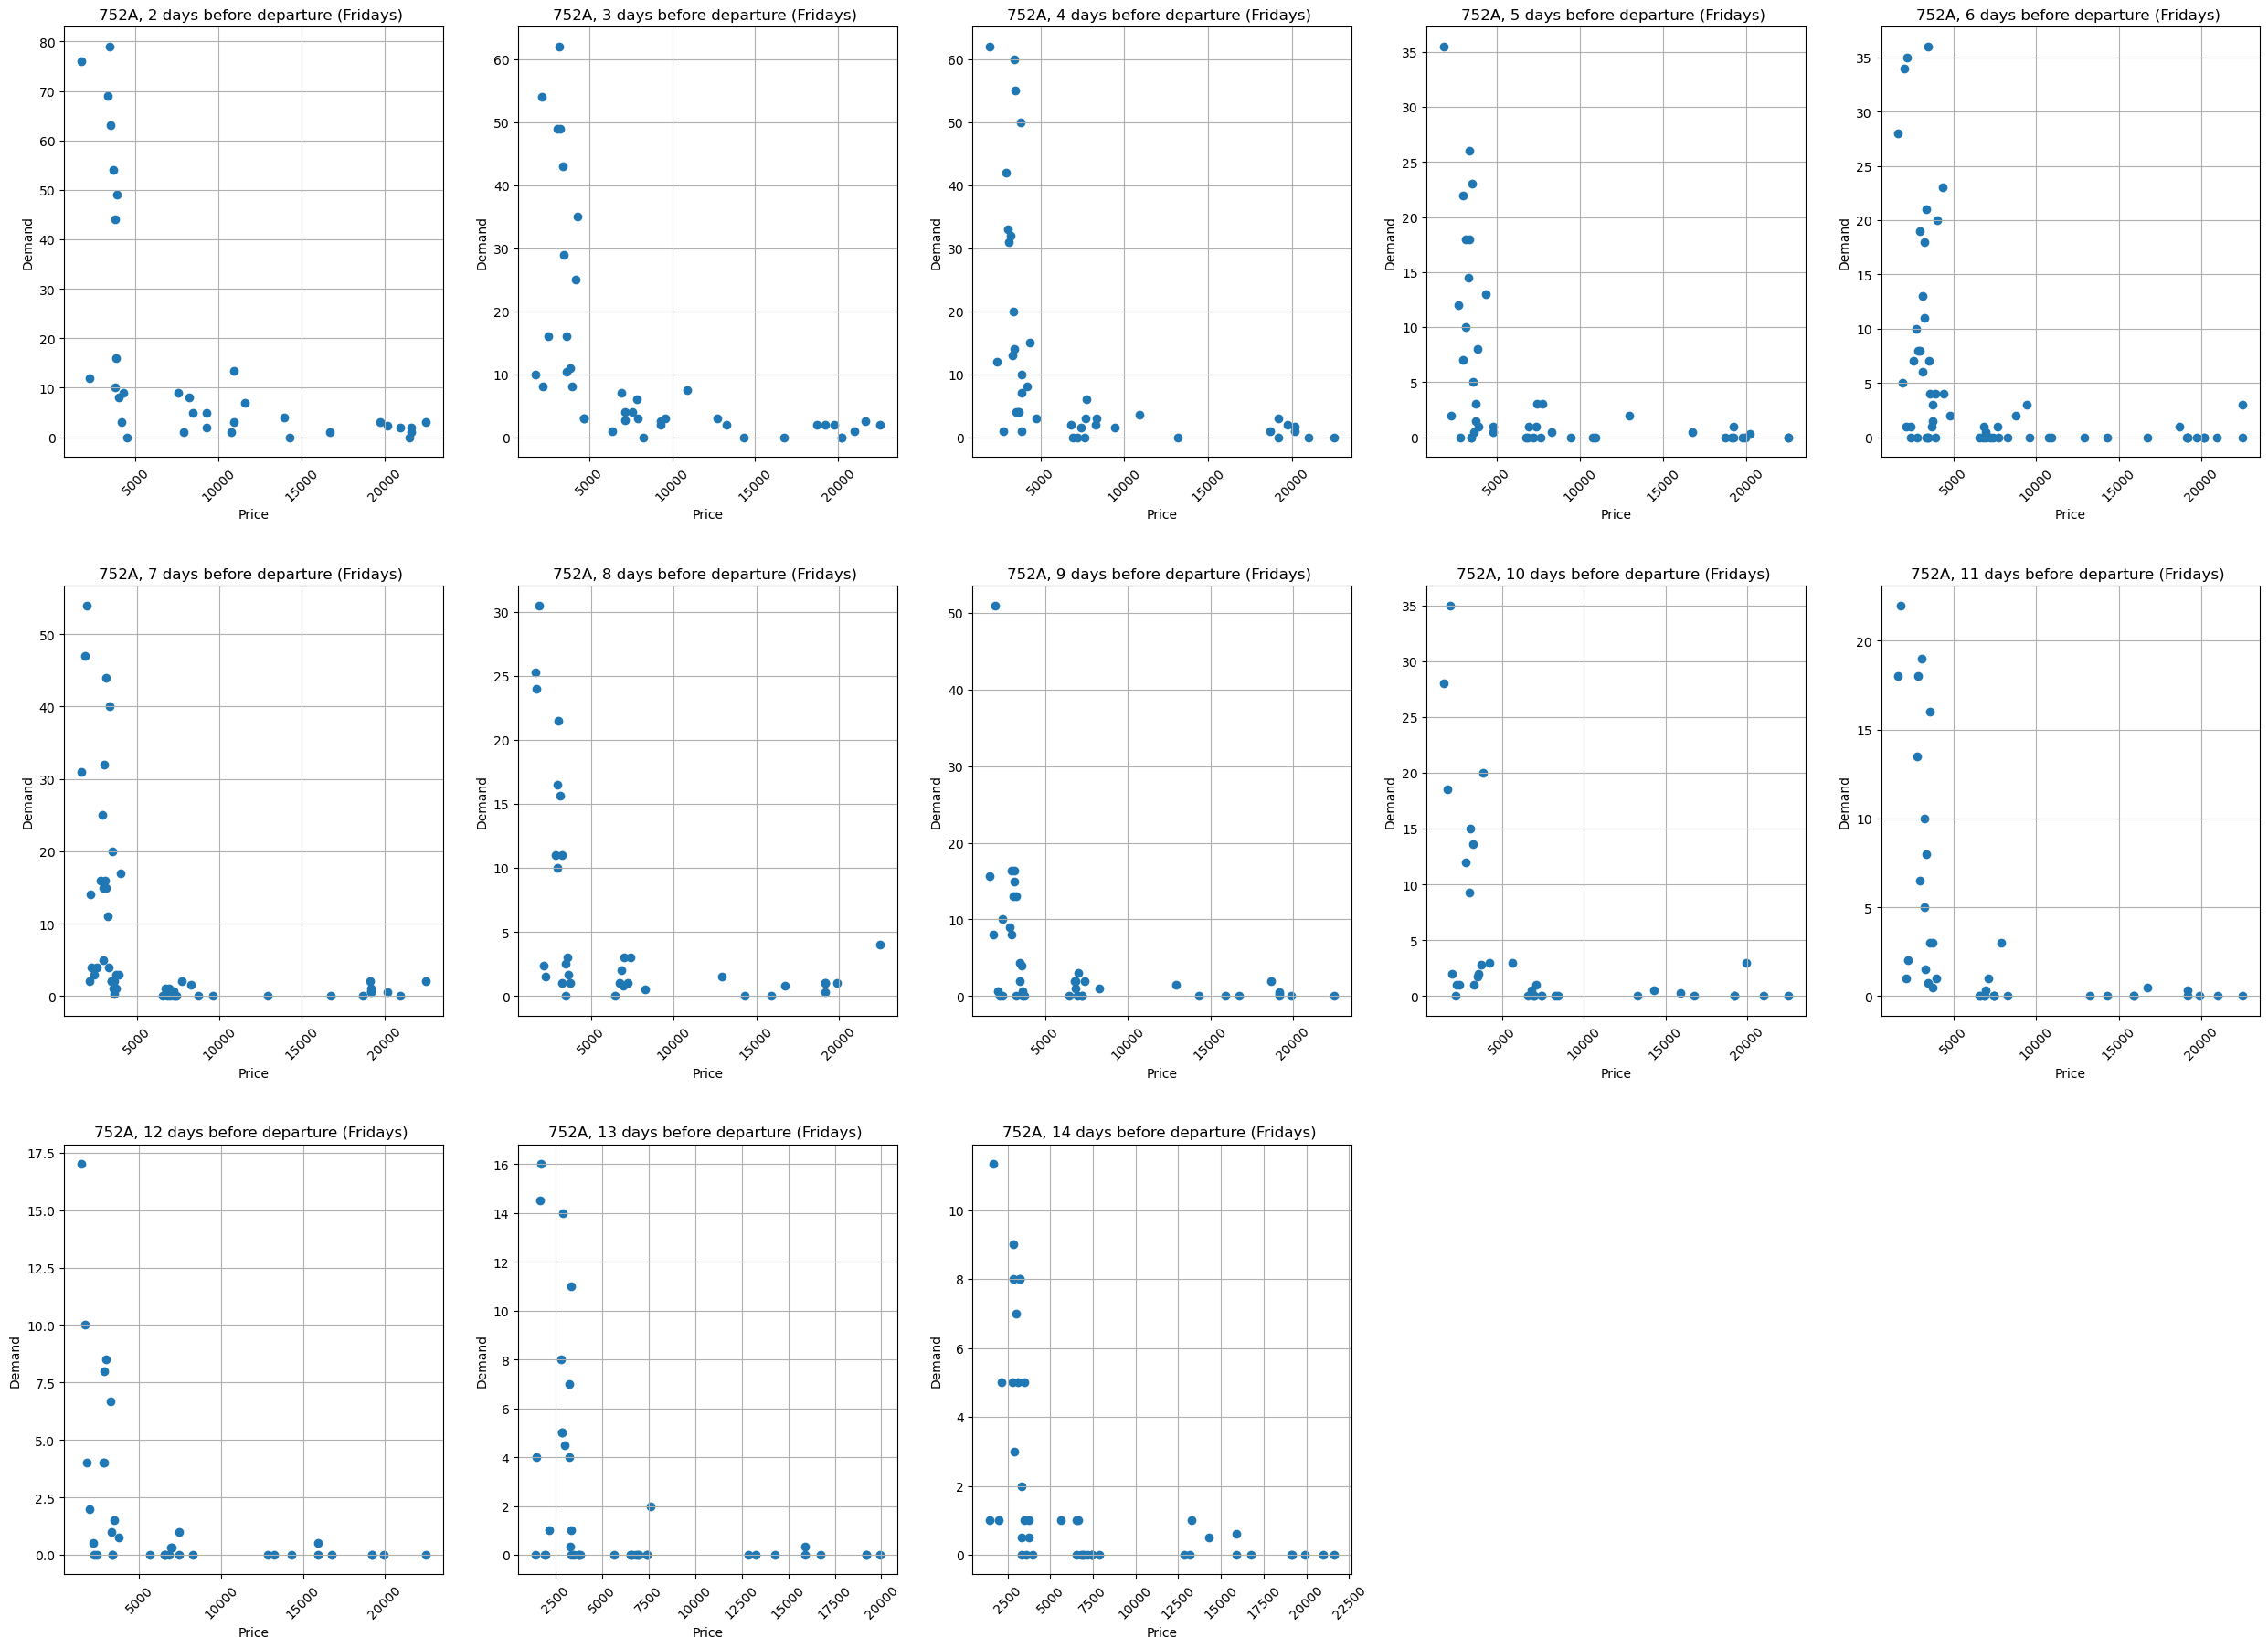

In [18]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'
scatter_plot(mean_p.loc[train_name].loc[wk_day], mean_d.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'mean')

## Data linearization and Box Cox Transformation

In [19]:
def linearize_vars(slised_data: pd.DataFrame, sliced_labels: pd.DataFrame)->(pd.DataFrame, pd.Series, pd.DataFrame):
    
    min_data=slised_data.min(axis=0)
    lin_data=slised_data-min_data+1.0
    log_lin_data=lin_data.apply(np.log, axis=0)
    
    shift_labels=sliced_labels+1.0
    log_shift_labels=shift_labels.apply(np.log, axis=0)
    
    log_lin_data=log_lin_data.mask(np.isinf(log_lin_data)).fillna(np.nan)
    log_shift_labels=log_shift_labels.mask(np.isinf(log_shift_labels)).fillna(np.nan)

    
    log_lin_data[np.isnan(log_shift_labels)]=np.nan
    log_shift_labels[np.isnan(log_lin_data)]=np.nan
    
    return lin_data, log_lin_data, min_data, shift_labels, log_shift_labels

In [20]:
%%time
log_lin_prices=pd.DataFrame(data=None, columns=prices.columns, index=prices.index, dtype="float")
lin_prices=pd.DataFrame(data=None, columns=prices.columns, index=prices.index, dtype="float")
log_shift_demand=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float")
shift_demand=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float")

list_ind=list(zip(sorted(np.array([uniq_train_num]*len(wk_days_mask)).ravel()), \
                  (wk_days_mask)*len(uniq_train_num)))
mu_ind=pd.MultiIndex.from_tuples(list_ind, names=("num", "day_name"))
min_df=pd.DataFrame(data=None, columns=prices.columns, index=mu_ind, dtype="float")

for num in uniq_train_num:
    for wk_day in wk_days_mask:
        lin_data, log_lin_data, min_data, shift_labels, log_shift_labels=linearize_vars(mean_p.loc[num].loc[wk_day], mean_d.loc[num].loc[wk_day])
        
        lin_prices.loc[num].loc[wk_day]=lin_data.values
        log_lin_prices.loc[num].loc[wk_day]=log_lin_data.values
        log_shift_demand.loc[num].loc[wk_day]=log_shift_labels.values
        shift_demand.loc[num].loc[wk_day]=shift_labels.values
        min_df.loc[num].loc[wk_day]=min_data

CPU times: user 1.38 s, sys: 15.7 ms, total: 1.39 s
Wall time: 1.39 s


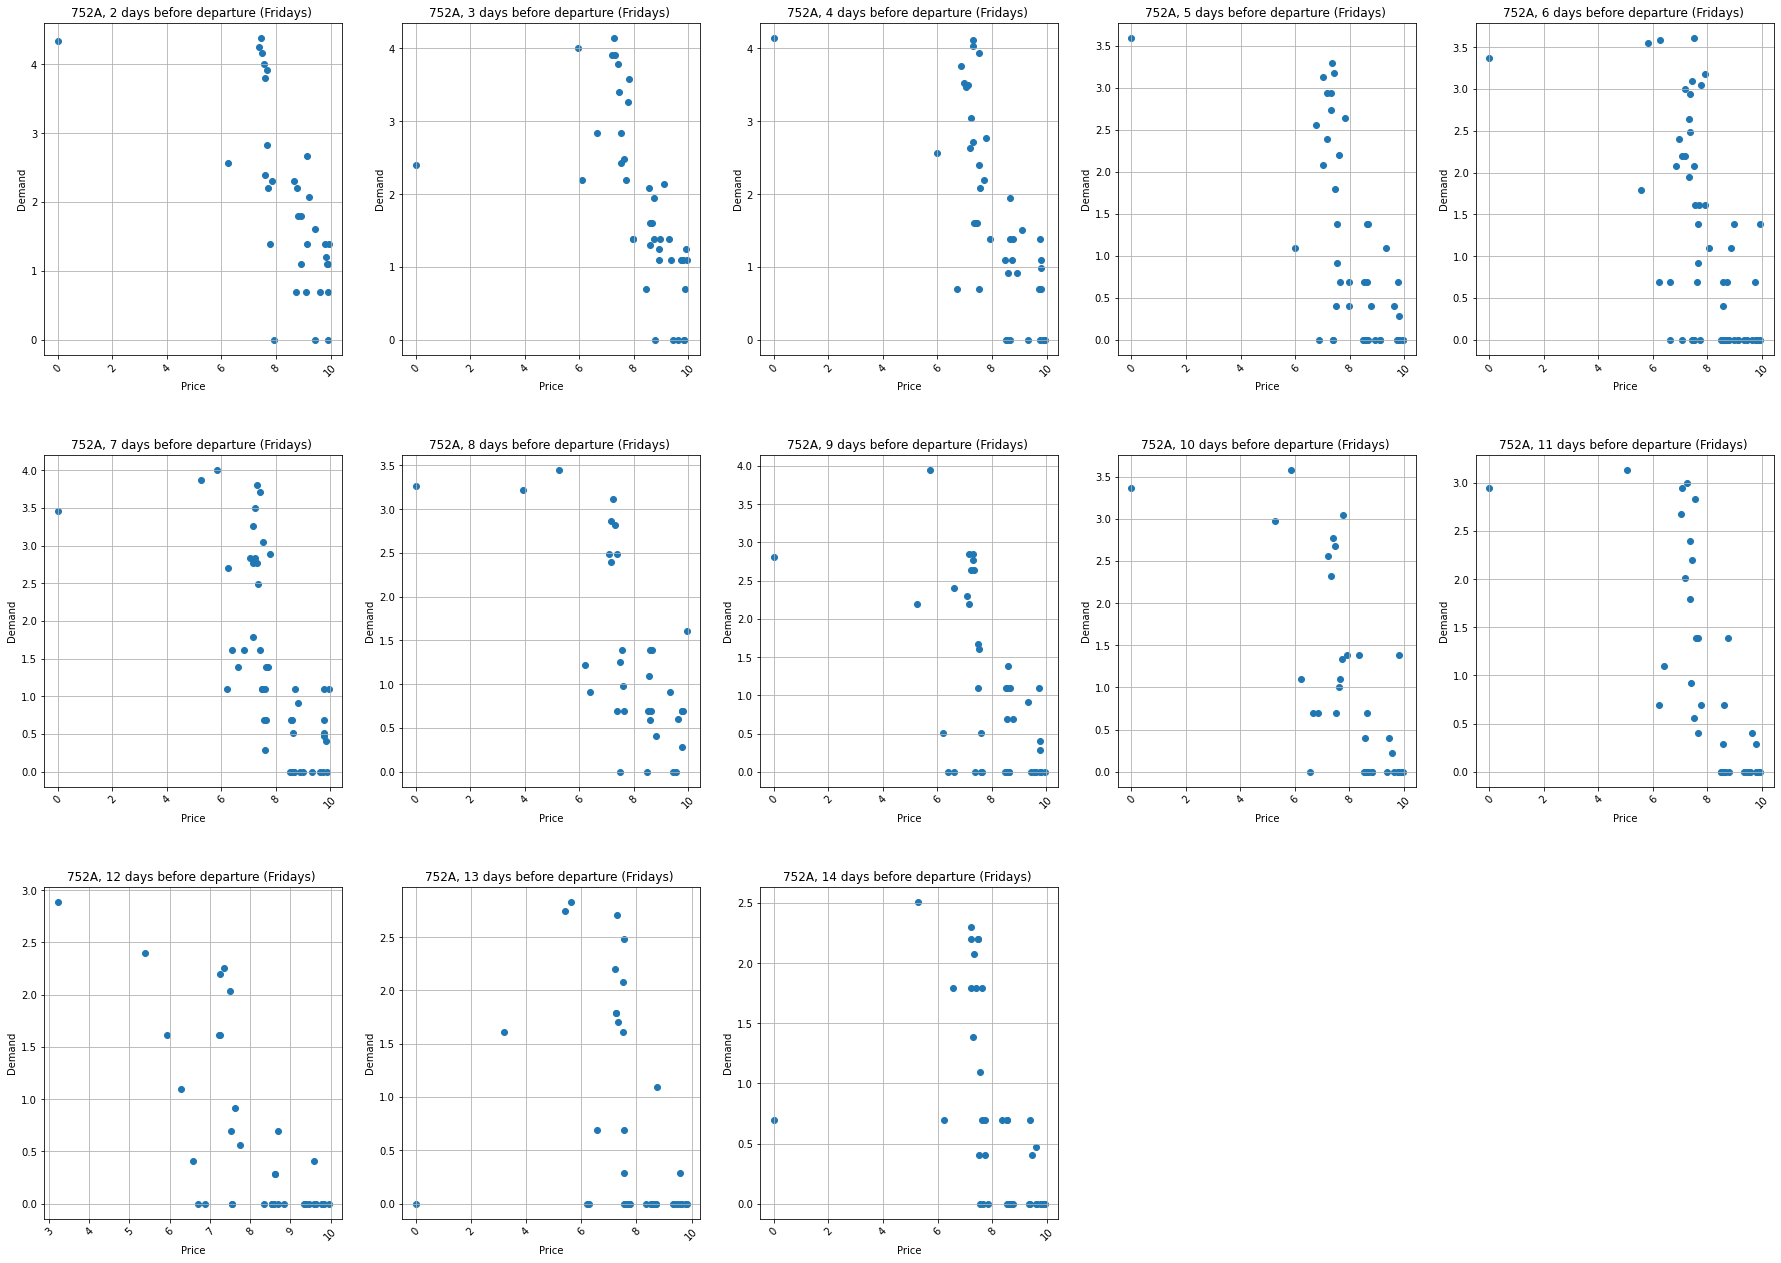

In [17]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

scatter_plot(log_lin_prices.loc[train_name].loc[wk_day], log_shift_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'liner cleared')

## Ensemble of Linear Regression Models

In [18]:
def r2_simple(labels: list, labels_pred: list)->np.float64:
    if not(np.nanvar(labels)==0):
        r2=1.-(np.nanvar(labels-labels_pred)/np.nanvar(labels))
    else:
        r2=np.nan
    
    return r2

def validation_model(data: tuple, labels: tuple):    
        
    data=data.dropna().values
    labels=labels.dropna().values
    
    line_reg = LinearRegression().fit(data.reshape(-1, 1), labels)
    labels_pred = line_reg.predict(data.reshape(-1, 1))
    r2=r2_simple(list(labels), labels_pred.ravel())
    
    return r2, labels_pred, line_reg

In [19]:
%%time
r2_df=pd.DataFrame(data=None, columns=prices.columns, index=mu_ind, dtype="float").sort_index()
pred_demand_df=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float").sort_index()
relined_demand_df=pd.DataFrame(data=None, columns=demand.columns, index=demand.index, dtype="float").sort_index()
model_df=pd.DataFrame(data=None, columns=prices.columns, index=mu_ind).sort_index()
A_df=pd.DataFrame(data=None, columns=prices.columns, index=demand.index, dtype="float").sort_index()
B_df=pd.DataFrame(data=None, columns=prices.columns, index=demand.index, dtype="float").sort_index()
for num in uniq_train_num:
    for wk_day in wk_days_mask:
        for day in log_lin_prices.columns:
            if not((len(log_lin_prices.loc[num].loc[wk_day][day].dropna())==0) | (len(log_shift_demand.loc[num].loc[wk_day][day].dropna())==0)):
                
                mask=~np.isnan(log_shift_demand.loc[num].loc[wk_day][day].astype(np.float64))
                
                r2, demand_pred, line_reg=validation_model(log_lin_prices.loc[num].loc[wk_day][day][mask], log_shift_demand.loc[num].loc[wk_day][day][mask])
                
                r2_df.loc[num].loc[wk_day][day]=r2
                
                pred_demand_df.loc[num].loc[wk_day][day][mask]=demand_pred
                relined_demand_df.loc[num].loc[wk_day][day][mask]=np.exp(demand_pred)-1
            
                model_df.loc[num].loc[wk_day][day]=line_reg
            
                A_df.loc[num, wk_day].T.loc[day]=line_reg.intercept_
                B_df.loc[num, wk_day].T.loc[day]=line_reg.coef_[0]

Wall time: 2min 37s


In [23]:
r2_df.to_csv(r'All_data\r2_df.csv')
pred_demand_df.to_csv(r'All_data\pred_demand_df.csv')

relined_demand_df.to_csv(r'All_data\relined_demand_df.csv')
model_df.to_csv(r'All_data\model_df.csv')

A_df.to_csv(r'All_data\A_df.csv')
B_df.to_csv(r'All_data\B_df.csv')

In [21]:
r2_df = pd.read_csv(r'All_data/r2_df.csv', index_col=[0, 1])
r2_df.columns.name='days'
r2_df.columns=r2_df.columns.astype(int)

pred_demand_df = pd.read_csv(r'All_data/pred_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
pred_demand_df.columns.name='days'
pred_demand_df.columns=pred_demand_df.columns.astype(int)

relined_demand_df = pd.read_csv(r'All_data/relined_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
relined_demand_df.columns.name='days'
relined_demand_df.columns=relined_demand_df.columns.astype(int)

model_df = pd.read_csv(r'All_data/model_df.csv', index_col=[0, 1])
model_df.columns.name='days'
model_df.columns=model_df.columns.astype(int)

A_df = pd.read_csv(r'All_data/A_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
A_df.columns.name='days'
A_df.columns=A_df.columns.astype(int)

B_df = pd.read_csv(r'All_data/B_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
B_df.columns.name='days'
B_df.columns=B_df.columns.astype(int)

In [11]:
def predicted_scatter_plot(sliced_x: pd.DataFrame, sliced_y: pd.DataFrame, sliced_predicted_y, days: np.array, fig_name: str):
    
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(31, 22)
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    
    for ax in axes.flat[len(days):]:
        ax.set_visible(False)
    for day, ax in zip(days, axes.flatten()):
        ax.scatter(sliced_x[day], sliced_y[day])
        ax.plot(sliced_x[day], sliced_predicted_y[day], color='green')
        ax.set_ylabel('Demand')
        ax.legend(['Predicted demand and price', 'Linearized demand and price'])
        ax.set_xlabel('Price')
        ax.set_title(train_name+', '+ str(day) + ' days before departure'+' ('+wk_day+'s) ')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid()
        
    # plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

In [ ]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

predicted_scatter_plot(log_lin_prices.loc[train_name].loc[wk_day], log_shift_demand.loc[train_name].loc[wk_day], 
                       pred_demand_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'predicted cleared')

In [23]:
def predicted_relined_scatter_plot(sliced_x: pd.DataFrame, sliced_y: pd.DataFrame, sliced_predicted_y, days: np.array, fig_name: str, train_type: str):
    
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(31, 22)
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    
    for ax in axes.flat[len(days):]:
        ax.set_visible(False)
    for day, ax in zip(days, axes.flatten()):
        sort_prices_mask=np.argsort(np.array(sliced_x[day]))
        sorted_y=np.array(sliced_predicted_y[day])[sort_prices_mask]
        ax.scatter(sliced_x[day], sliced_y[day])
        ax.plot(sliced_x[day][sort_prices_mask], pd.Series(sorted_y).interpolate(method='linear', axis=0, limit_direction='both', limit=100).values, color='green')
        ax.set_ylabel('Demand')
        ax.legend(['Demand approximation', 'Demand'])
        ax.set_xlabel('Price')
        ax.set_title(train_type+', '+ str(day) + ' days before departure'+' ('+wk_day+'s) ')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid()
        
    #plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

In [22]:
exp_A_df=pd.DataFrame(data=np.exp(np.float64(A_df)), columns=A_df.columns, index=A_df.index, dtype="float")
relined_dem_df=exp_A_df*np.power(mean_p-min_df+1., B_df)-1.

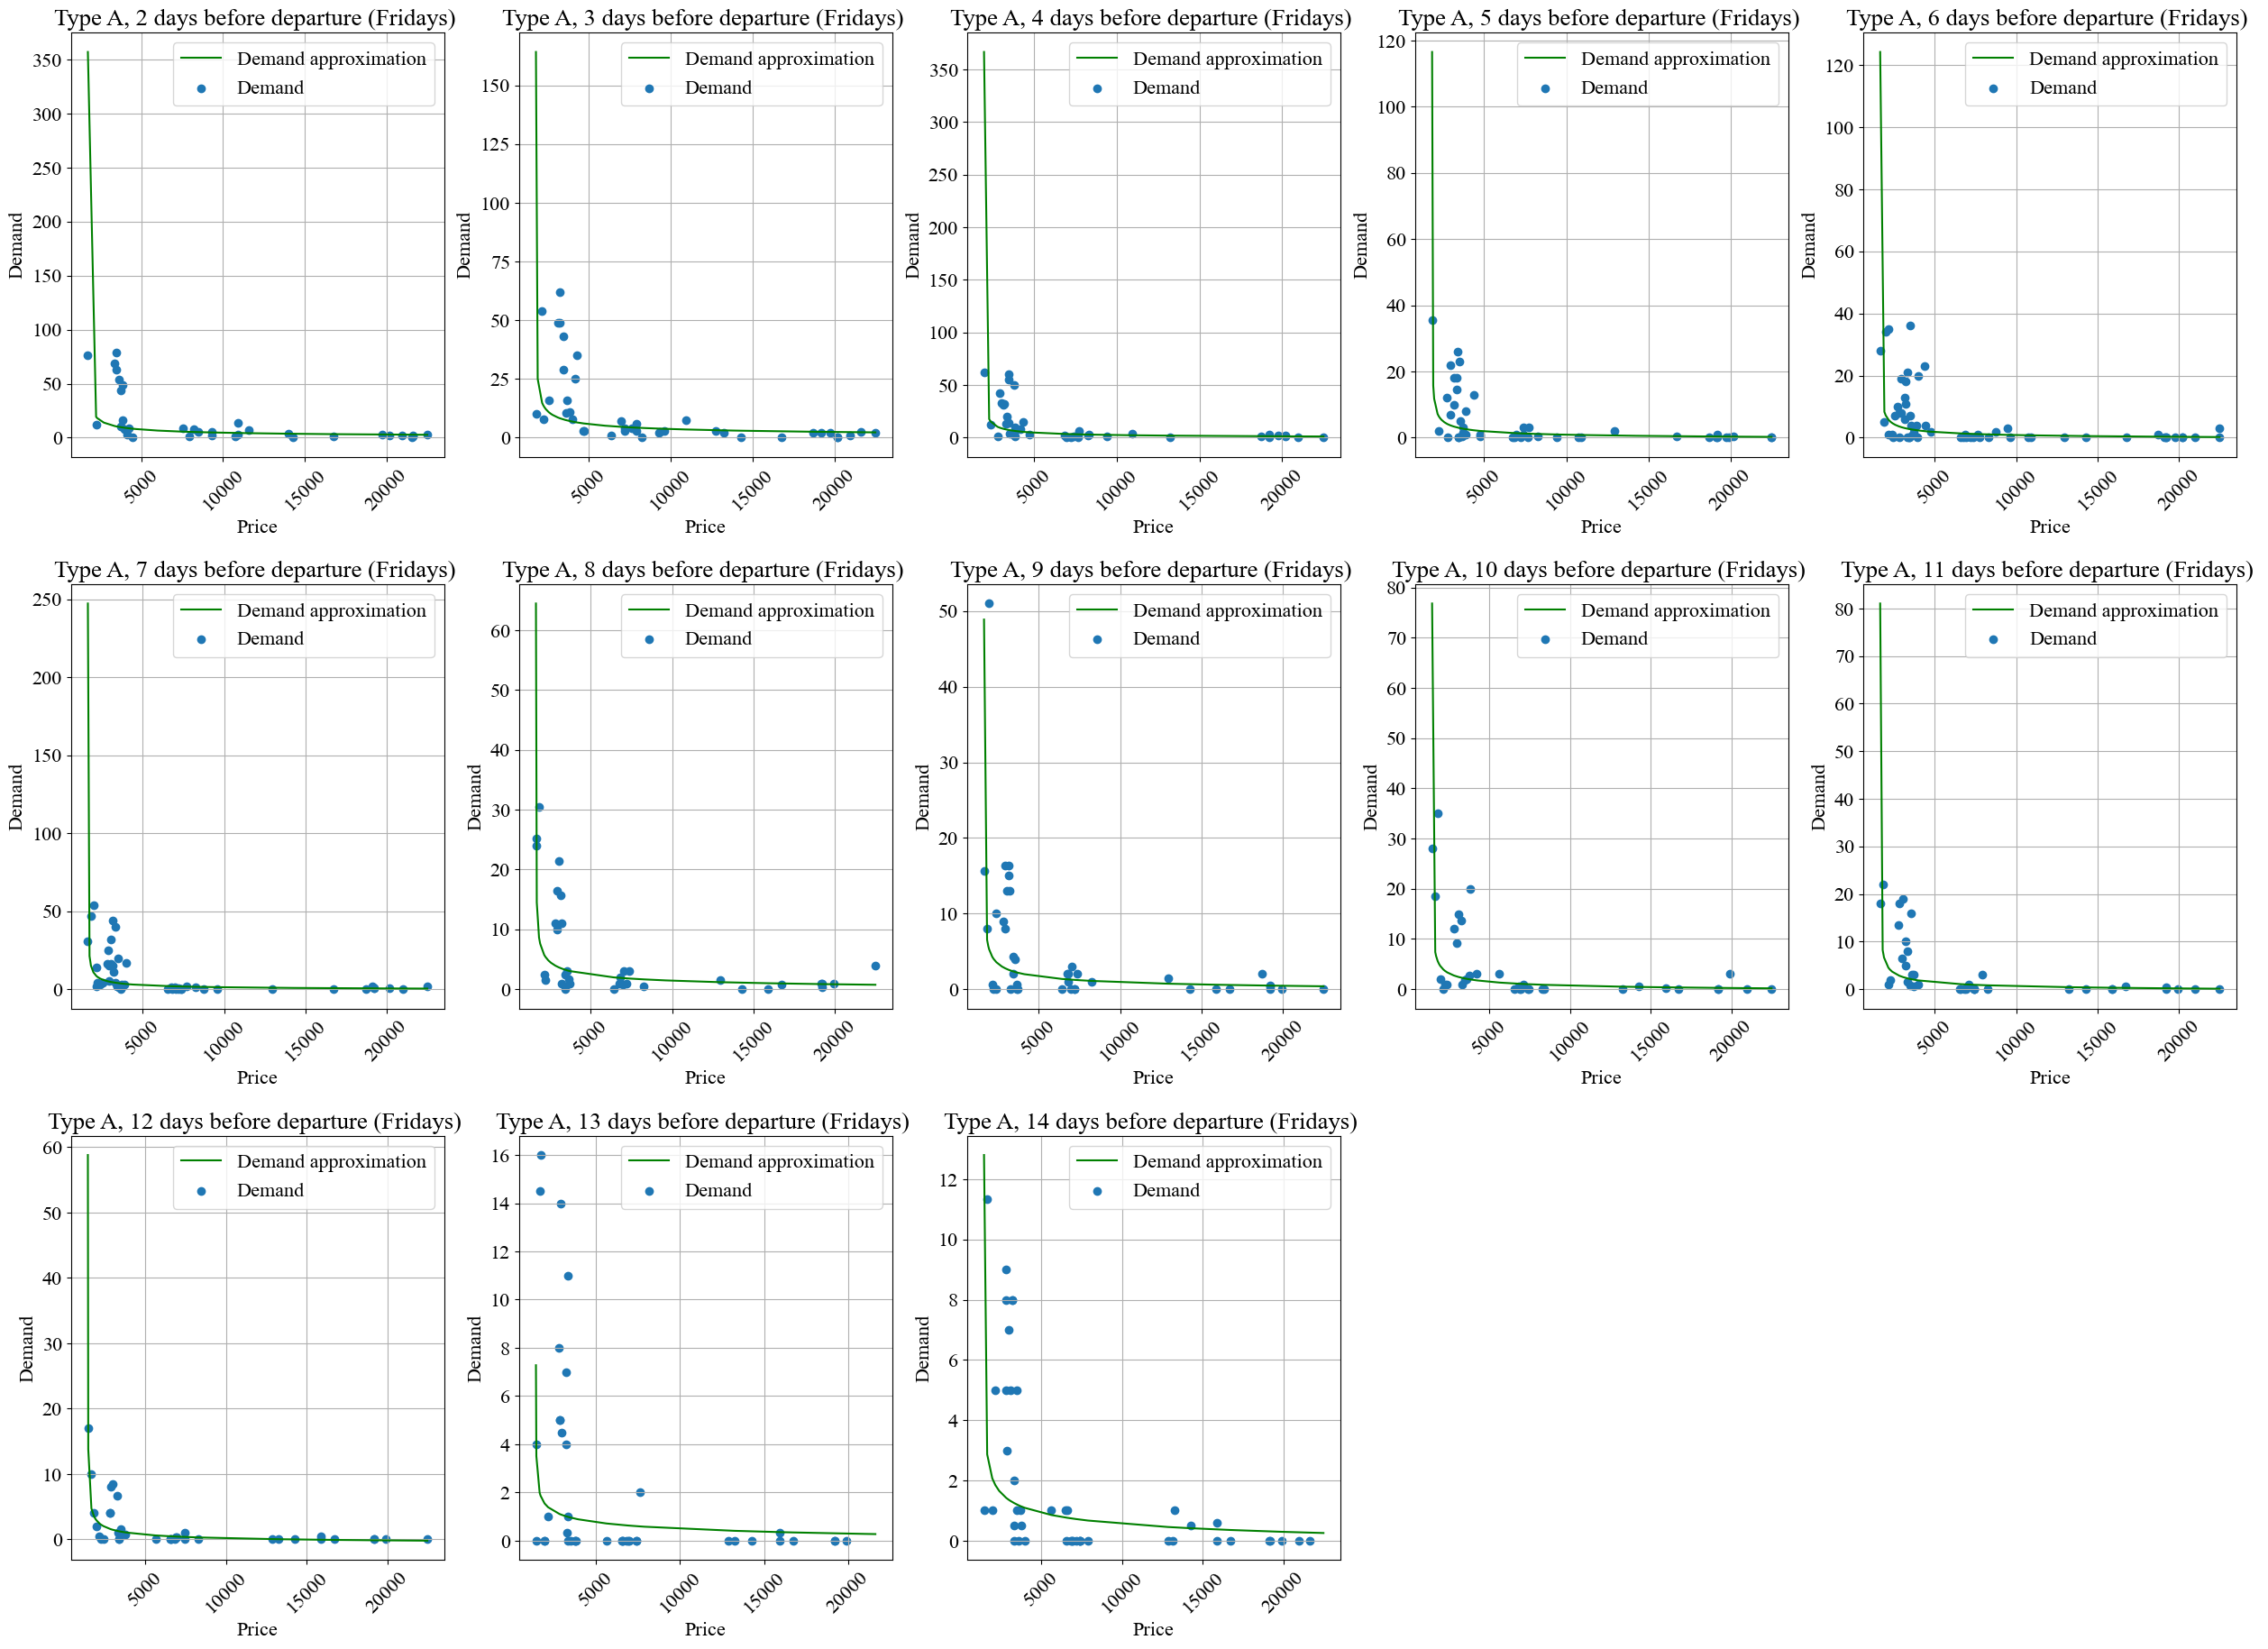

In [182]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

predicted_relined_scatter_plot(mean_p.loc[train_name].loc[wk_day], mean_d.loc[train_name].loc[wk_day], 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'predicted relined cleared', train_type="Type A")

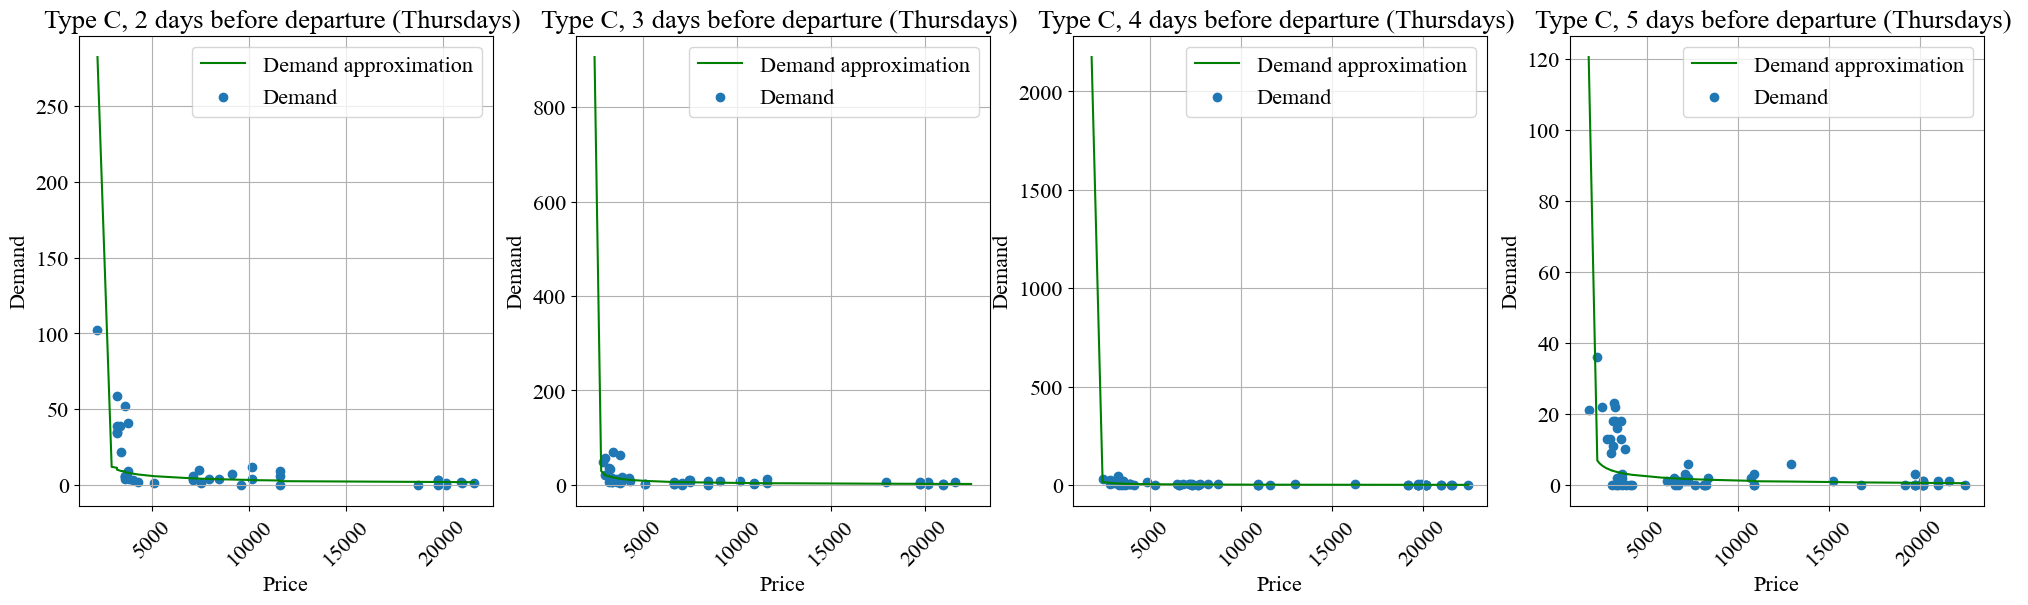

In [19]:
days=np.arange(2, 6)
train_name='780А'
wk_day='Thursday'

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
predicted_relined_scatter_plot(prices.loc[train_name].loc[wk_day], demand.loc[train_name].loc[wk_day], 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, 'Figure9', train_type='Type C')
#plt.savefig(r'All_data\Fig\780А\Relined_demand.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Residuals of the models

In [24]:
epsilon=mean_d-relined_dem_df
epsilon=epsilon.mask(np.isinf(epsilon)).fillna(np.nan)
relativ_epsilon=epsilon/relined_dem_df 
relativ_epsilon=relativ_epsilon.mask(np.isinf(relativ_epsilon)).fillna(np.nan)
abs_eps=np.abs(epsilon)

In [21]:
days=np.arange(2, 15)
train_name='752А'
wk_day='Friday'

def eps_hists(sliced_x: pd.DataFrame, days: np.array, fig_name: str, train_type: str):
    
    fig, axes = plt.subplots(3, 5)
    fig.set_size_inches(31, 22)
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    
    for ax in axes.flat[len(days):]:
        ax.set_visible(False)
    for day, ax in zip(days, axes.flatten()):
        
        adf_results_dict=dict()
        interp_adf_results_dict=dict()
        
        sns.histplot(sliced_x[day][~np.isnan(sliced_x[day])], ax=ax, element="step", kde=False, alpha=1)
        ax.set_ylabel('Counts')
        ax.set_xlabel('\u03B4')
        ax.set_title(train_type+', '+ str(day) + ' days before departure'+' ('+wk_day+'s) ')
        plt.setp(ax.get_xticklabels(), rotation=45)
        ax.grid()
        
        # Дики-Фуллера
        adf_result = adfuller(sliced_x[day][~np.isnan(sliced_x[day])])
        adf_results_dict[day]=adf_result
        
            # Интерпретация теста
        if (adf_result[0]<=adf_result[4]['5%']) and (adf_result[1]<=0.05):
            interp_adf_results_dict[day]='H0 can be rejected'
        else:
            interp_adf_results_dict[day]='H0 cannot be rejected'
        
            # Вывод интерпретации теста на график
        tl = ((ax.get_xlim()[1] - ax.get_xlim()[0])*0.010 + ax.get_xlim()[0], \
              (ax.get_ylim()[1] - ax.get_ylim()[0])*0.95 + ax.get_ylim()[0])
        ax.text(tl[0], tl[1], r"ADF result: {}".format(interp_adf_results_dict[day]))
        
    # plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

In [ ]:
days=np.arange(2, 6)
train_name='780А'
wk_day='Thursday'

eps_hists(relativ_epsilon.loc[train_name].loc[wk_day, :14], days, train_name+' '+wk_day+' '+'gr rel_eps cleared', train_type='Type C')
#plt.savefig(r'All_data\Fig\780А\Relative_errors.pdf', transparent=True, bbox_inches='tight')
plt.show()

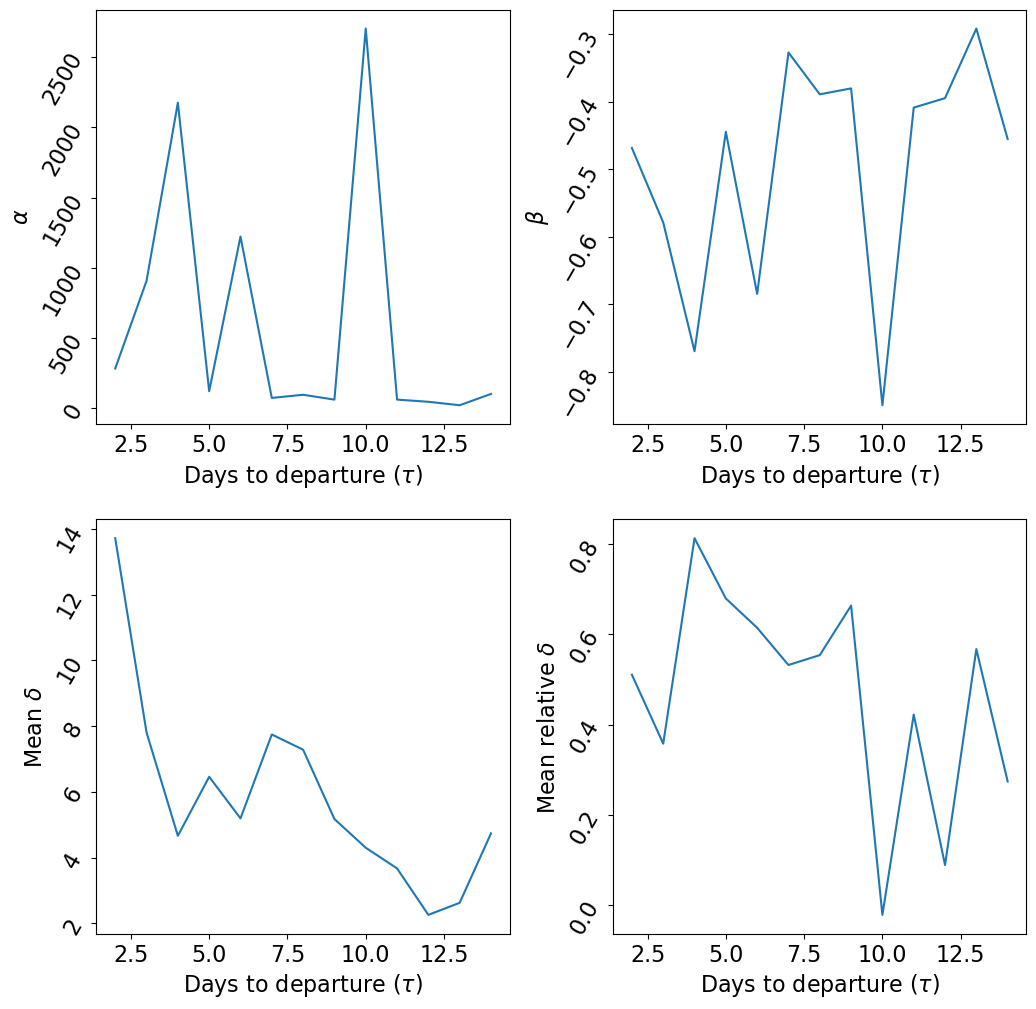

In [28]:
train_name='780А'
wk_day='Thursday'

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.23)

plot_data_list=list([exp_A_df.loc[train_name].loc[wk_day, :14].mean(axis=0), B_df.loc[train_name].loc[wk_day, :14].mean(axis=0), 
                     abs_eps.loc[train_name].loc[wk_day, :14].mean(axis=0), relativ_epsilon.loc[train_name].loc[wk_day, :14].mean(axis=0)])
ylabels_list=list([r'${\alpha}$', r'${\beta}$', r'Mean ${\delta}$', 
                  r'Mean relative ${\delta}$'])
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for i, ax in enumerate(axes.flat):
    plot_data_list[i].plot(ax=ax)
    ax.set_ylabel(ylabels_list[i])
    ax.set_xlabel(r'Days to departure ($\tau$)')
    ax.tick_params(axis='y', labelrotation=60)
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
#plt.savefig(r'All_data/Fig/C_780A/Model_parameters.pdf', transparent=True, bbox_inches='tight')
plt.show()

# Optimization

## Price constraints

In [ ]:
train_num='780А'
index=['B1', 'B2', 'C1', 'C2']
general_mean_pr_list=dict()
for i, cl in enumerate(index):
    general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_num].groupby('class'))[1][i]).ravel()

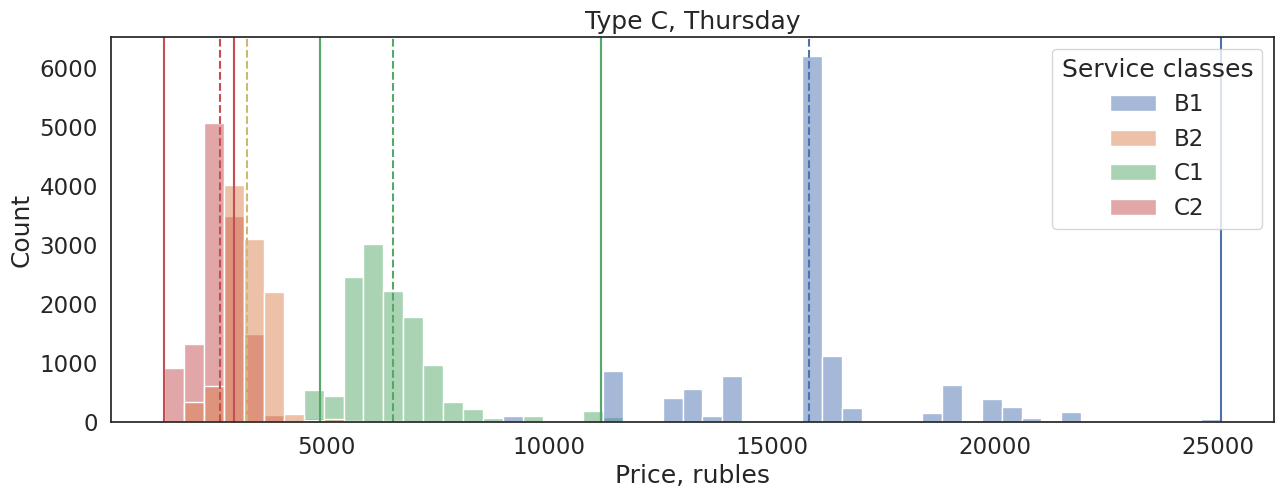

In [32]:
train_type='Type С'
wk_day='Thursday'
gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
mean_val_prices_ser=gmp_df.mean(axis=1)
sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
max_price_cons=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc['B1'].max())
min_price_cons=(max_price_cons.sort_values(ascending=True).shift().fillna(gmp_df.loc['C2'].min())-1).sort_index()
colors=['b', 'y', 'g', 'r']
sns.set(rc={'figure.figsize':(15,5)}, style="white", font_scale=1.5)
g=sns.histplot(gmp_df.T)
plt.xlabel('Price, rubles')
leg = g.axes.get_legend()
new_title = 'Service classes'
leg.set_title(new_title)
plt.title(train_type+', '+wk_day)
for i, j in enumerate(index):
    plt.axvline(mean_val_prices_ser.loc[j], color=colors[i], linestyle='--')
    plt.axvline(max_price_cons.loc[j], color=colors[i])
    plt.axvline(min_price_cons.loc[j], color=colors[i])
#plt.savefig(r'All_data/Fig/C_780A/Prices_hist.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Monte Carlo model validation

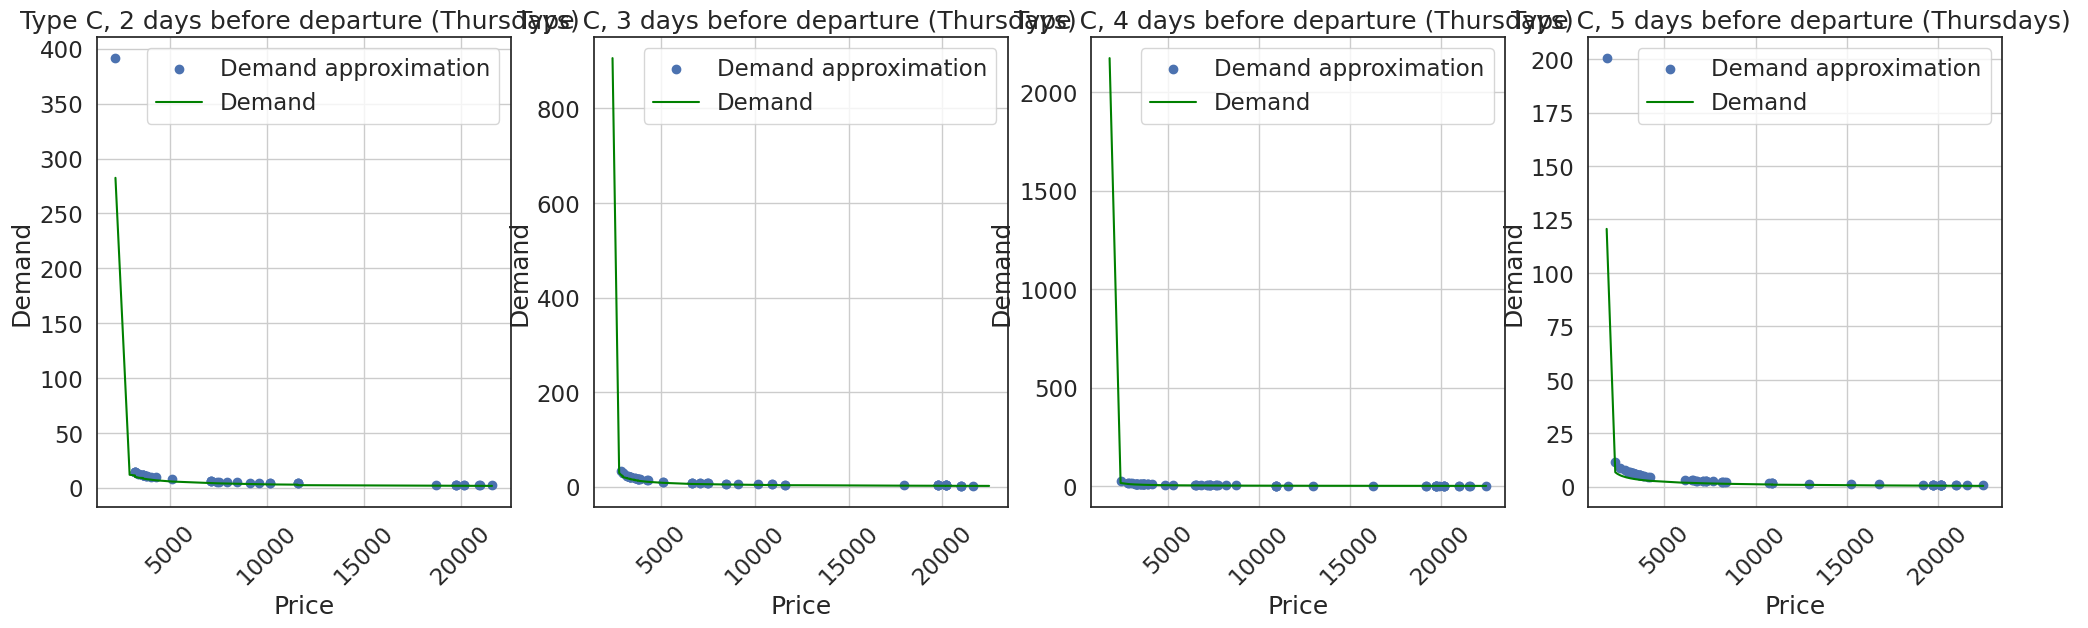

CPU times: user 6.61 s, sys: 47.1 ms, total: 6.66 s
Wall time: 6.66 s


In [37]:
%%time
days=np.arange(2, 6)
train_names=list(['780А'])
train_name='780А'
wk_days=list(['Thursday'])
wk_day='Thursday'
days_to_dept=13
num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)
min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0])
B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
val_prices=prices.loc[train_name].loc[wk_day, :14][~np.isnan(demand.loc[train_name].loc[wk_day, :14])]
val_demand=demand.loc[train_name].loc[wk_day, :14][~np.isnan(prices.loc[train_name].loc[wk_day, :14])]
val_list=list()
val_errors=list()
for i in range(100):
    val_eps=list()
    for k in range(4):
        for day in range(2, days_to_dept+2):
            rel_eps_arr=np.array(relativ_epsilon.loc[train_name].loc[wk_day, day])
            rel_eps_arr=rel_eps_arr[~np.isnan(rel_eps_arr)]
            val_eps.append(EmpiricalDistribution(rel_eps_arr).rvs(1))
            val_errors.append(val_eps)
        val_eps=np.array(val_eps).ravel()
        relined_val_dem_df=(exp_A_df.loc[train_name].loc[wk_day, :14]*np.power(val_prices-min_df.loc[train_name].loc[wk_day, :14]+1., B_df.loc[train_name].loc[wk_day, :14])-1.)*(1+val_eps.T)
        val_list.append(relined_val_dem_df.T.values)
        val_eps=list()
mean_val_list=np.mean(val_list, axis=0)
mean_val_df=relined_val_dem_df.copy()
for i in range(2, 14):
    mean_val_df[i]=mean_val_list[i-2]
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
predicted_relined_scatter_plot(prices.loc[train_name].loc[wk_day], mean_val_df, 
                       relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'val_model', train_type='Type C')
#plt.savefig(r'All_data/Fig/C_780A/Validation.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Optimization algorithm

In [ ]:
%%time

trains=[['752А', 'Thursday'], ['752А', 'Saturday'], ['752А', 'Tuesday'], ['752А', 'Monday'], ['752А', 'Wednesday'], ['752А', 'Wednesday']]
train_names=list(['780А'])
wk_days=list(['Thursday'])
days_to_dept=13
main_dict=dict()
wk_days_dict=dict()
res_dict=dict()
popsize=5
class optim_fun:
    def __init__(self, A, min_p, B, eps, arg_shape):
        self.A=A
        self.min_p=min_p
        self.B=B
        self.eps=eps
        self.arg_shape=arg_shape
    def revenue(self, x):
        self.x=x
        rev = -1.*np.sum(self.x*((self.A*np.power(self.x-self.min_p+1., self.B)-1.)*(1.+self.eps)))
        return rev
    def f_con(self, x):
        self.x=x
        res_con=np.sum(np.array(((self.A*np.power(self.x-self.min_p+1., self.B)-1.)*(1.+self.eps))).reshape(self.arg_shape), axis=1)
        return res_con

for train_nd in trains:
    train_name=train_nd[0]
    wk_day=train_nd[1]
    print(train_name)
    print(wk_day)
    num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
    arg_shape=(num_classes, days_to_dept)
    min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
    B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
    A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0]) #
    class_names=np.sort(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
    integrality=list()
    for i in range(len(min_p)):
        integrality.append(True)
    integrality=np.array(integrality)
    general_mean_pr_list=dict()
    for i, cl in enumerate(class_names):
        general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()
    gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
    mean_val_prices_ser=gmp_df.mean(axis=1)
    sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
    price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
    max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
    min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
    max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
    min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()
    min_price[min_price<min_p]=min_p[min_price<min_p]
    max_price[min_price>max_price]=min_price[min_price>max_price]
    bounds = Bounds(min_price, max_price, keep_feasible = True) # keep_feasible=False
    max_con=np.array(places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
    min_con=np.ones(arg_shape[0])
    opt_prices=list()
    opt_eps=list()
    opt_rev=list()
    iterations=100
    i=iterations
    errors=0 
    while i>0:
        try:
            eps=list()
            for k in range(4):
                for day in range(2, days_to_dept+2):
                    rel_eps_arr=np.array(relativ_epsilon.loc[train_name].loc[wk_day, day])
                    rel_eps_arr=rel_eps_arr[~np.isnan(rel_eps_arr)]
                    eps.append(EmpiricalDistribution(rel_eps_arr).rvs(1))
            eps=np.array(eps).ravel()
            optim_f=optim_fun(A, min_p, B, eps, arg_shape)
            nlc = NonlinearConstraint(optim_f.f_con, min_con, max_con, keep_feasible=True)
            min_res =  differential_evolution(optim_f.revenue, bounds, constraints=(nlc), popsize=popsize)
            if min_res.success==False:
                go_to_except=1/0
            opt_prices.append(min_res.x)
            opt_eps.append(eps)
            opt_rev.append(min_res.fun)
            i-=1
            errors=0
            clear_output(wait=True)
            print(train_name)
            print(wk_day)
            print('Number of iterations: ', str(iterations-i))
            print('Found errors: ', str(errors))
        except Exception:
            errors+=1
            clear_output(wait=True)
            print(train_name)
            print(wk_day)
            print('Number of iterations: ', str(iterations-i))
            print('Found errors: ', str(errors))
            if errors>=100:
                traceback.print_exc()
                break
            else:
                traceback.print_exc()
                continue
    res_dict['prices']=opt_prices
    res_dict['eps']=opt_eps
    res_dict['rev']=opt_rev
    wk_days_dict[wk_day]=res_dict
    main_dict[train_name]=wk_days_dict
    with open(r'All_data/Opt_data/'+train_name+'_'+wk_day+'_'+str(popsize)+'.npy', 'wb') as f:
        np.save(f, np.array(opt_prices))
        np.save(f, np.array(opt_eps))
        np.save(f, np.array(opt_rev))

## Validation of optimization results. Estimation of optimal prices, demand and revenue.

In [ ]:
train_num='780A'
day='Thursday'

opt_prices=main_dict[train_num][day]['prices']
opt_eps=main_dict[train_num][day]['eps']

mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev)

def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1., B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem

def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev

val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices, opt_eps):
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

mean_val_rev=-1*np.mean(val_rev_list)
mean_val_dem=np.mean(val_dem_list, axis=0)
print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))

rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()

print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

In [48]:
with open(r'All_data\Opt_data\752A_Friday_5.npy', 'wb') as f:
    np.save(f, np.array(opt_prices))
    np.save(f, np.array(opt_eps))
    np.save(f, np.array(opt_rev))

In [ ]:
with open(r'All_data\Opt_data\752A_Friday_5.npy', 'rb') as f:
    opt_prices_de_14 = np.load(f)
    opt_eps_de_14 = np.load(f)
    opt_rev_de_14 = np.load(f)

In [62]:
train_names=list(['752A'])
train_name='752А'
train_num='752А'
wk_day=list(['Friday'])
days_to_dept=13
day='Friday'

num_classes=len(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)

min_p=np.tile(np.array(min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
B=np.tile(np.array(B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
A=np.tile(np.array(exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])

class_names=np.sort(prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
        
general_mean_pr_list=dict()

for i, cl in enumerate(class_names):
    general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()

gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
mean_val_prices_ser=gmp_df.mean(axis=1)
sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()

min_price[min_price<min_p]=min_p[min_price<min_p]
max_price[min_price>max_price]=min_price[min_price>max_price]
        
max_con=np.array(places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
min_con=np.ones(arg_shape[0])

opt_prices=opt_prices_de_14
opt_eps=opt_eps_de_14

mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev_de_14)

def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem

def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev

val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

mean_val_rev=-1*np.nanmean(val_rev_list)
mean_val_dem=np.nanmean(val_dem_list, axis=0)

print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))
rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()

print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

Mean validation revenue 1201939.8729126465
Mean validation demand [ 12.96376073  32.92997253  29.9426658  257.99413214]
Tickets [ 15.7037037   36.26923077  41.42307692 258.76      ]
Optimal prices >= min prices? {True}
Optimal prices <= max prices? {True}
Revenue of Russian Railways 1248440.117471278
Revenue update, %: -3.724667599821923


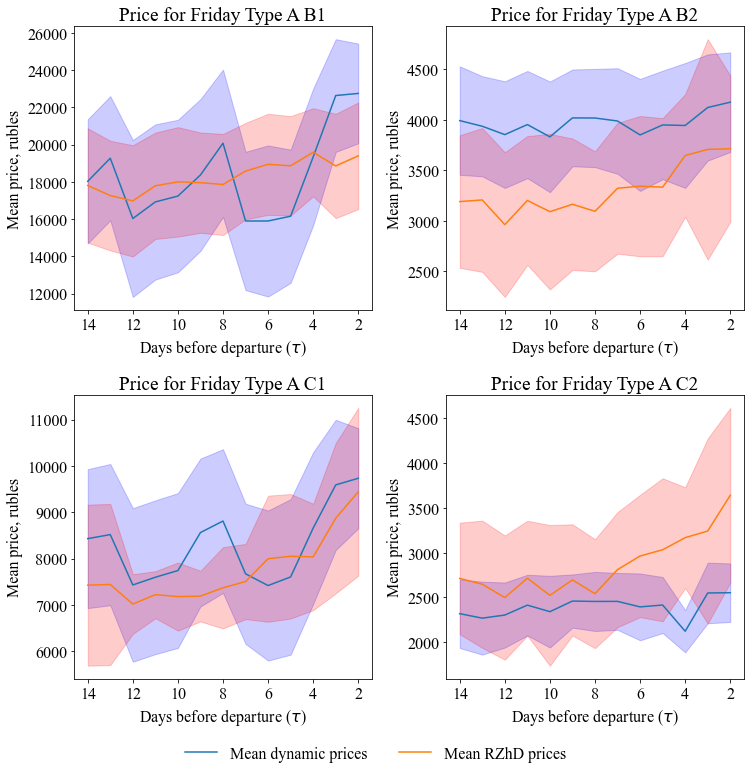

In [54]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

ev_mean_pr=np.mean(opt_prices_de_14, axis=0).reshape(4, 13)
ev_std_pr=np.std(opt_prices_de_14, axis=0).reshape(4, 13)

pl_std=ev_mean_pr+ev_std_pr
mi_std=ev_mean_pr-ev_std_pr

rgd_mean_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std=rgd_mean_pr+rgd_std_pr
rgd_mi_std=rgd_mean_pr-rgd_std_pr


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_pr[cl])
    ax.fill_between(days_b_d, pl_std[cl], mi_std[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_pr[cl])
    ax.fill_between(days_b_d, rgd_pl_std[cl], rgd_mi_std[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean price, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Price for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.figlegend([r'Mean dynamic prices',
               r'Mean RZhD prices'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name=r'All_data\Fig\759А\Figure12_t_752A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

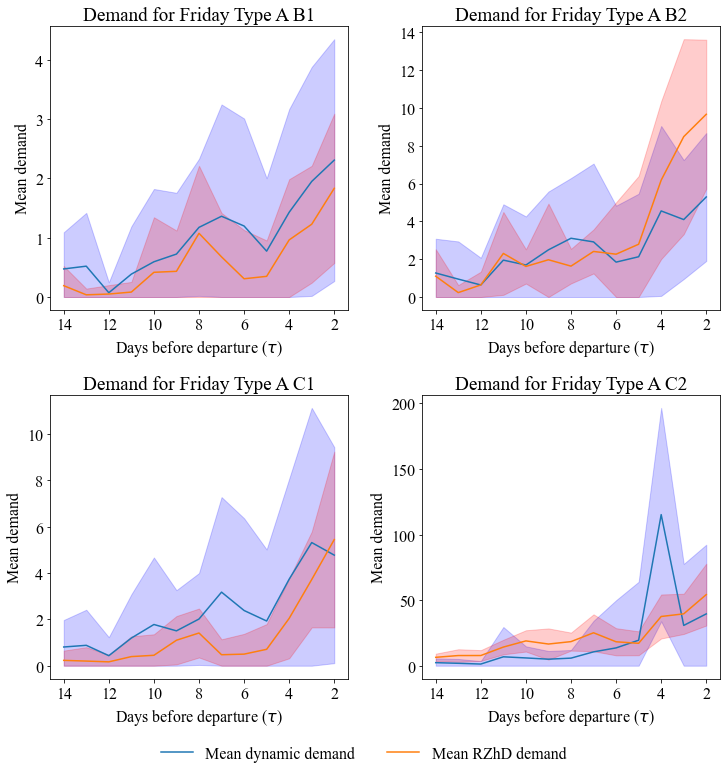

In [55]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

def validate_demand(x, A, min_p, B, eps):
    dem = np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps))
    return dem

val_dem_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)

ev_mean_dem=np.mean(val_dem_list, axis=0).reshape(4, 13)
ev_std_dem=np.std(val_dem_list, axis=0).reshape(4, 13)

pl_std_dem=ev_mean_dem+ev_std_dem
mi_std_dem=ev_mean_dem-ev_std_dem
pl_std_dem[pl_std_dem<0]=0.
mi_std_dem[mi_std_dem<0]=0.

rgd_mean_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std_dem=rgd_mean_dem+rgd_std_dem
rgd_mi_std_dem=rgd_mean_dem-rgd_std_dem

for i, _ in enumerate(rgd_pl_std_dem):
    rgd_pl_std_dem[i][rgd_pl_std_dem[i]<0]=0.
    rgd_mi_std_dem[i][rgd_mi_std_dem[i]<0]=0.

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_dem[cl])
    ax.fill_between(days_b_d, pl_std_dem[cl], mi_std_dem[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_dem[cl])
    ax.fill_between(days_b_d, rgd_pl_std_dem[cl], rgd_mi_std_dem[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean demand')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Demand for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic demand',
               r'Mean RZhD demand'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name=r'All_data\Fig\759А\Figure13_t_752A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

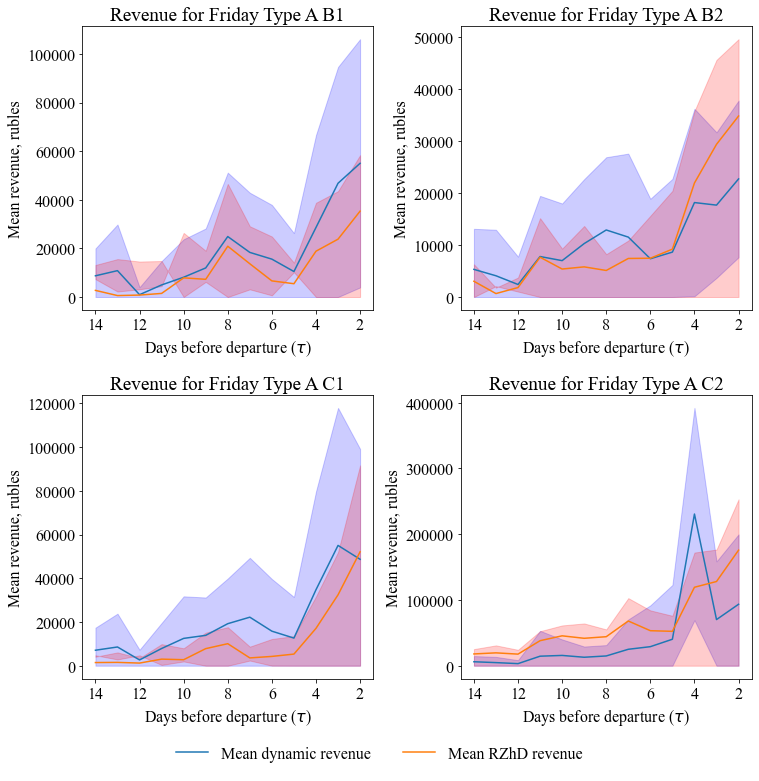

In [56]:
from matplotlib.ticker import MaxNLocator

train_type='Type A'

def revenue(x, A, min_p, B, eps):
    rev = x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps))
    return rev
val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)
ev_mean_rev=np.mean(val_rev_list, axis=0).reshape(4, 13)
ev_std_rev=np.std(val_rev_list, axis=0).reshape(4, 13)
pl_std_rev=ev_mean_rev+ev_std_rev
mi_std_rev=ev_mean_rev-ev_std_rev
pl_std_rev[pl_std_rev<0]=0.
mi_std_rev[mi_std_rev<0]=0.
rgd_mean_rev=mean_d.loc[train_num].loc[day, :14]*mean_p.loc[train_num].loc[day, :14]
rgd_std_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanstd, axis=0))
rgd_mean_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanmean, axis=0))
rgd_pl_std_rev=rgd_mean_rev+rgd_std_rev
rgd_mi_std_rev=rgd_mean_pr-rgd_std_rev
for i, _ in enumerate(rgd_pl_std_dem):
    rgd_pl_std_rev[i][rgd_pl_std_rev[i]<0]=0.
    rgd_mi_std_rev[i][rgd_mi_std_rev[i]<0]=0.
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)
cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_rev[cl])
    ax.fill_between(days_b_d, pl_std_rev[cl], mi_std_rev[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_rev[cl])
    ax.fill_between(days_b_d, rgd_pl_std_rev[cl], rgd_mi_std_rev[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean revenue, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Revenue for '+day+' '+train_type +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic revenue',
               r'Mean RZhD revenue'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name=r'All_data\Fig\759А\Figure14_t_752A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

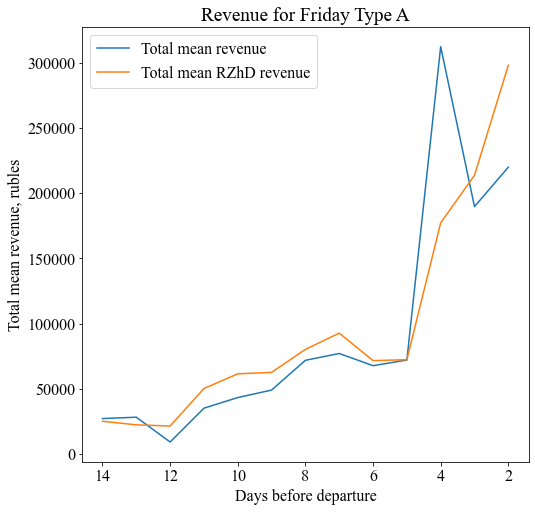

In [57]:
rgd_mean_sum_rev=np.nansum(list(rgd_mean_rev), axis=0)
revv=np.nansum(list(ev_mean_rev), axis=0)
fig, ax = plt.subplots(1, figsize=(8, 8))
cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
ax.plot(days_b_d, revv, label='Total mean revenue')
ax.plot(days_b_d, rgd_mean_sum_rev, label='Total mean RZhD revenue')
ax.set_ylabel('Total mean revenue, rubles')
ax.set_xlabel('Days before departure')
ax.set_title('Revenue for '+day+' '+train_type)
ax.legend(loc='upper left')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig_name='All_data\Fig\Figure15_752A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

In [58]:
pd.DataFrame({'Opt_sum_rev': revv, 'RZhD_sum_rev': rgd_mean_sum_rev, 'Opt_conf': np.sum(ev_std_rev, axis=0), 'RZhD_conf': np.sum(rgd_std_rev, axis=0)}).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
Opt_sum_rev,219817.429483,189620.888862,312186.096968,71986.094095,67687.773694,77027.401640,71800.304056,48974.411014,43255.032136,35086.941728,9158.066937,28202.320379,27137.111919
RZhD_sum_rev,297956.630000,213624.882197,177157.533838,72255.733712,71577.920824,92642.186397,80166.508148,62574.229697,61436.657222,50188.530909,21441.824444,22323.273333,25094.206748
Opt_conf,222893.604638,213209.909553,262407.864313,131298.016632,120526.507647,113133.789192,77453.415163,62205.609818,70139.751553,71637.150199,18352.378857,51772.975609,37918.865999
RZhD_conf,154655.516452,104022.311444,101062.887903,51692.901189,65257.572408,58812.304449,47397.682811,49509.960261,43469.169857,31807.084238,13119.056659,18721.893695,17906.155091


# Incremental learning

## Preprocessing and Feature Extraction

### New Capacity

In [17]:
folder='new_data.csv'

new_data = pd.read_csv(folder, parse_dates=['date'], index_col=[0], encoding='utf-8')

new_data['weekday'] = new_data['date'].dt.weekday
new_data['day_name'] = new_data['date'].dt.day_name()

new_weekdays = new_data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday').set_index('weekday')['day_name'].to_dict()
new_uniq_train_names=new_data['train'].unique()
new_uniq_train_num=new_data['num'].unique()
new_wk_days_mask=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

new_places = new_data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='places', aggfunc={'places': np.nanmean})

train_name='759А'
wk_day='Thursday'

new_places.loc[train_name].loc[wk_day, :14].head()

days                1    2     3   4     5     6     7     8   9   10  11  12  \
date       class                                                                
2021-03-25 B1      1.0  NaN   NaN NaN   NaN   NaN   NaN   NaN NaN NaN NaN NaN   
           C1     19.0  NaN   NaN NaN   NaN   NaN   NaN   NaN NaN NaN NaN NaN   
           C2     73.0  NaN   NaN NaN   NaN   NaN   NaN   NaN NaN NaN NaN NaN   
2021-04-01 B1      NaN  NaN  12.0 NaN  15.0  17.0  17.0  17.0 NaN NaN NaN NaN   
           B2      2.0  3.0  17.0 NaN  26.0  30.0  32.0  32.0 NaN NaN NaN NaN   

days              13  14  
date       class          
2021-03-25 B1    NaN NaN  
           C1    NaN NaN  
           C2    NaN NaN  
2021-04-01 B1    NaN NaN  
           B2    NaN NaN

### New Demand and prices

In [18]:
new_demand=(new_places-new_places.shift(axis=1))
new_demand[new_demand<0.]=np.nan
new_demand=new_demand.drop(columns=1, axis=0)
new_prices = new_data.pivot_table(index=['num', 'day_name', 'date', 'class'], columns='days', values='price')
new_prices_cons=new_prices.copy()
new_prices=new_prices.drop(columns=1, axis=0)
new_demand.loc[train_name].loc[wk_day, :14].head()

days               2     3   4   5    6    7    8   9   10  11  12  13  14
date       class                                                          
2021-03-25 B1     NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
           C1     NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
           C2     NaN   NaN NaN NaN  NaN  NaN  NaN NaN NaN NaN NaN NaN NaN
2021-04-01 B1     NaN   NaN NaN NaN  2.0  0.0  0.0 NaN NaN NaN NaN NaN NaN
           B2     1.0  14.0 NaN NaN  4.0  2.0  0.0 NaN NaN NaN NaN NaN NaN

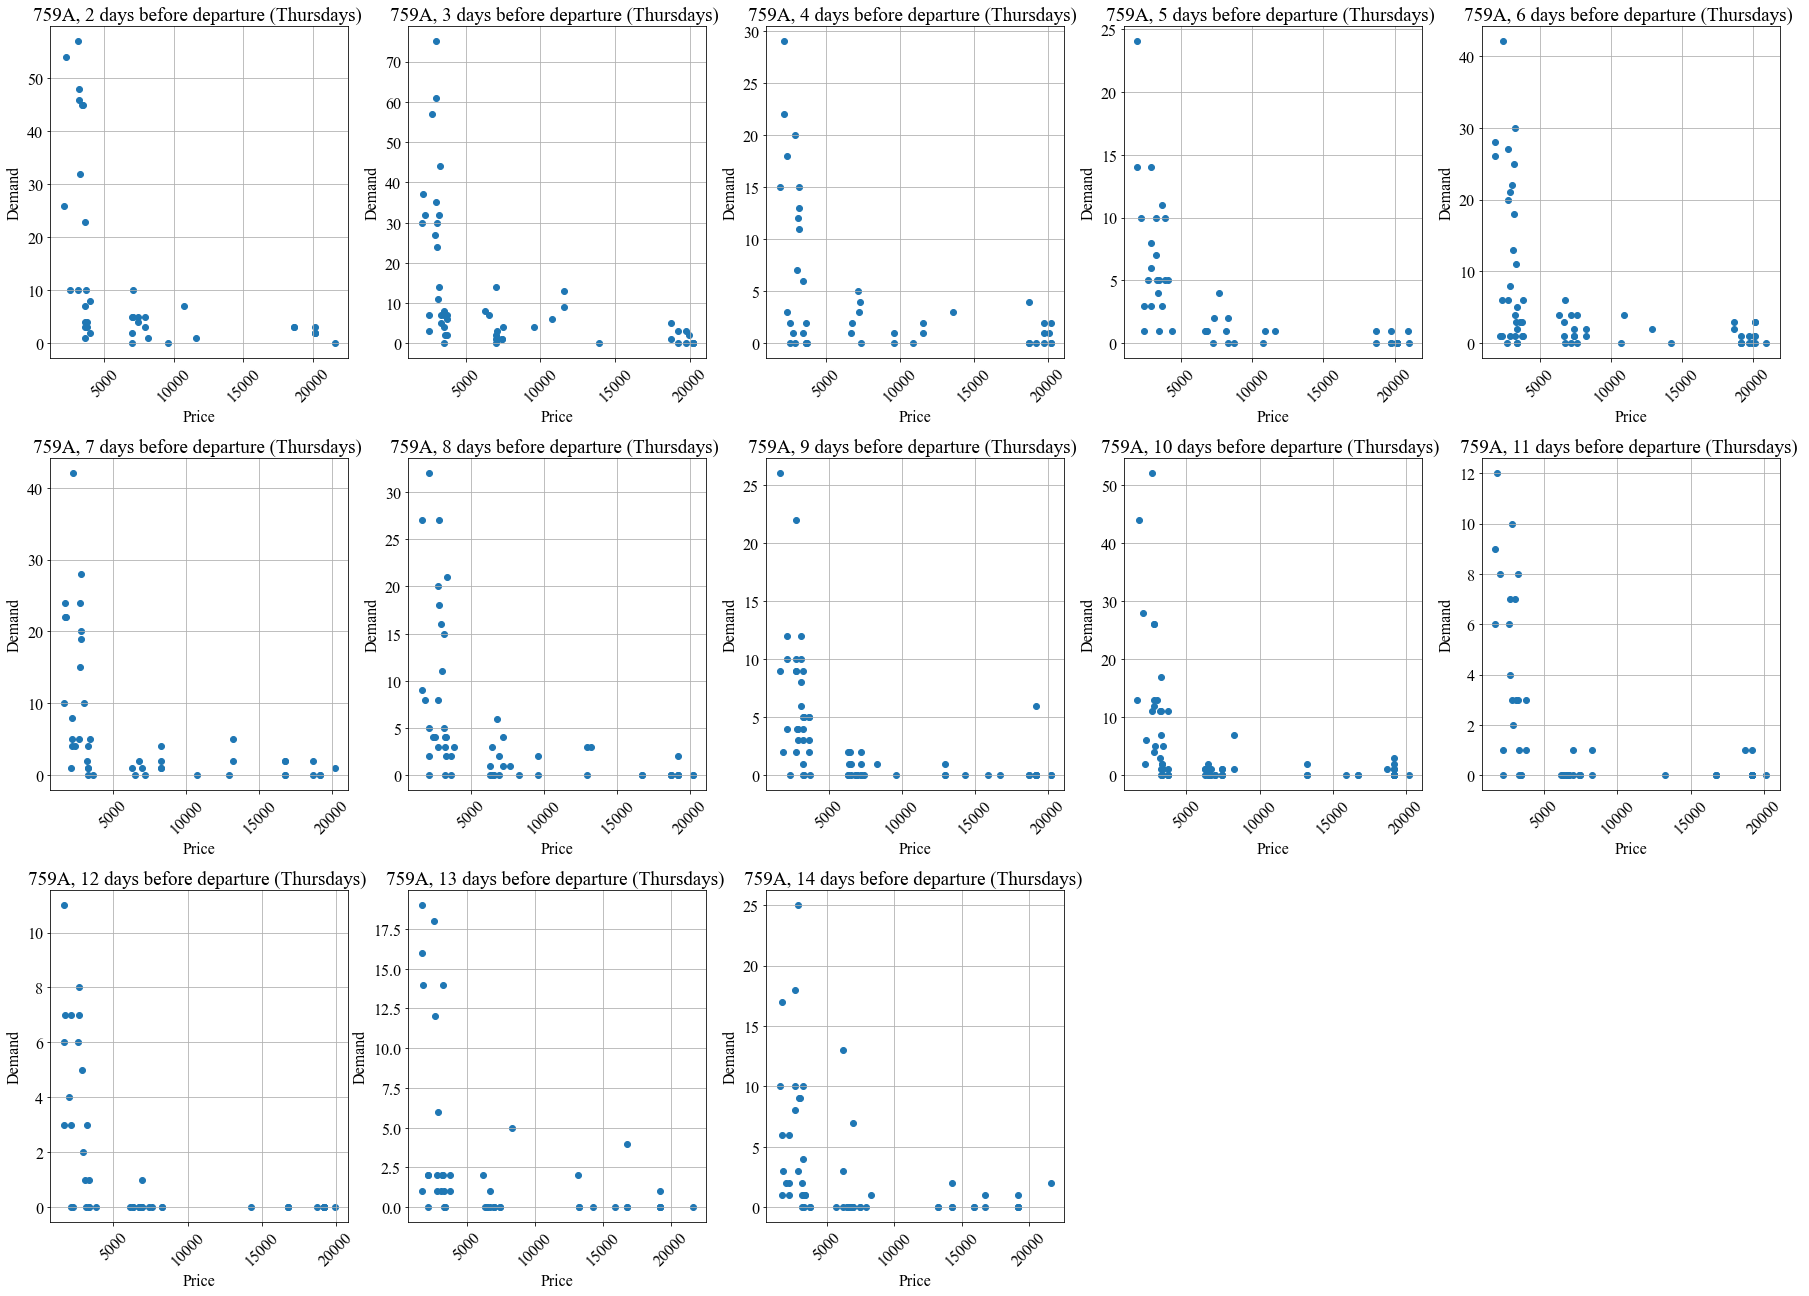

In [23]:
days=np.arange(2, 15)    
scatter_plot(new_prices.loc[train_name].loc[wk_day], new_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'no cleaned')

### Removing duplicates and averaging

In [24]:
new_mean_prices=pd.DataFrame(data=np.nan, columns=new_prices.columns, index=new_prices.index, dtype="float")
new_mean_demand=pd.DataFrame(data=np.nan, columns=new_demand.columns, index=new_demand.index, dtype="float")
for num in new_uniq_train_num:
    for wk_day in new_wk_days_mask:
        for day in new_demand.columns:
            new_pr_dem_piv=mean_duplicate_prices(new_prices.loc[num].loc[wk_day][day], 
                                             new_demand.loc[num].loc[wk_day][day])
            
            new_flat_pr_dem_piv=flat_grouped_classes(new_pr_dem_piv)
            
            new_mean_prices.loc[num, wk_day].T.loc[day]=new_flat_pr_dem_piv.set_index(['date', 'class'])['prices']
            new_mean_demand.loc[num, wk_day].T.loc[day]=new_flat_pr_dem_piv.set_index(['date', 'class'])['demand']

In [26]:
new_mean_prices.to_csv('new_mean_prices.csv')
new_mean_demand.to_csv('new_mean_demand.csv')

In [19]:
new_mean_p = pd.read_csv('new_mean_prices.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_mean_p.columns.name='days'
new_mean_p.columns=new_mean_p.columns.astype(int)
new_mean_d = pd.read_csv('new_mean_demand.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_mean_d.columns.name='days'
new_mean_d.columns=new_mean_d.columns.astype(int)

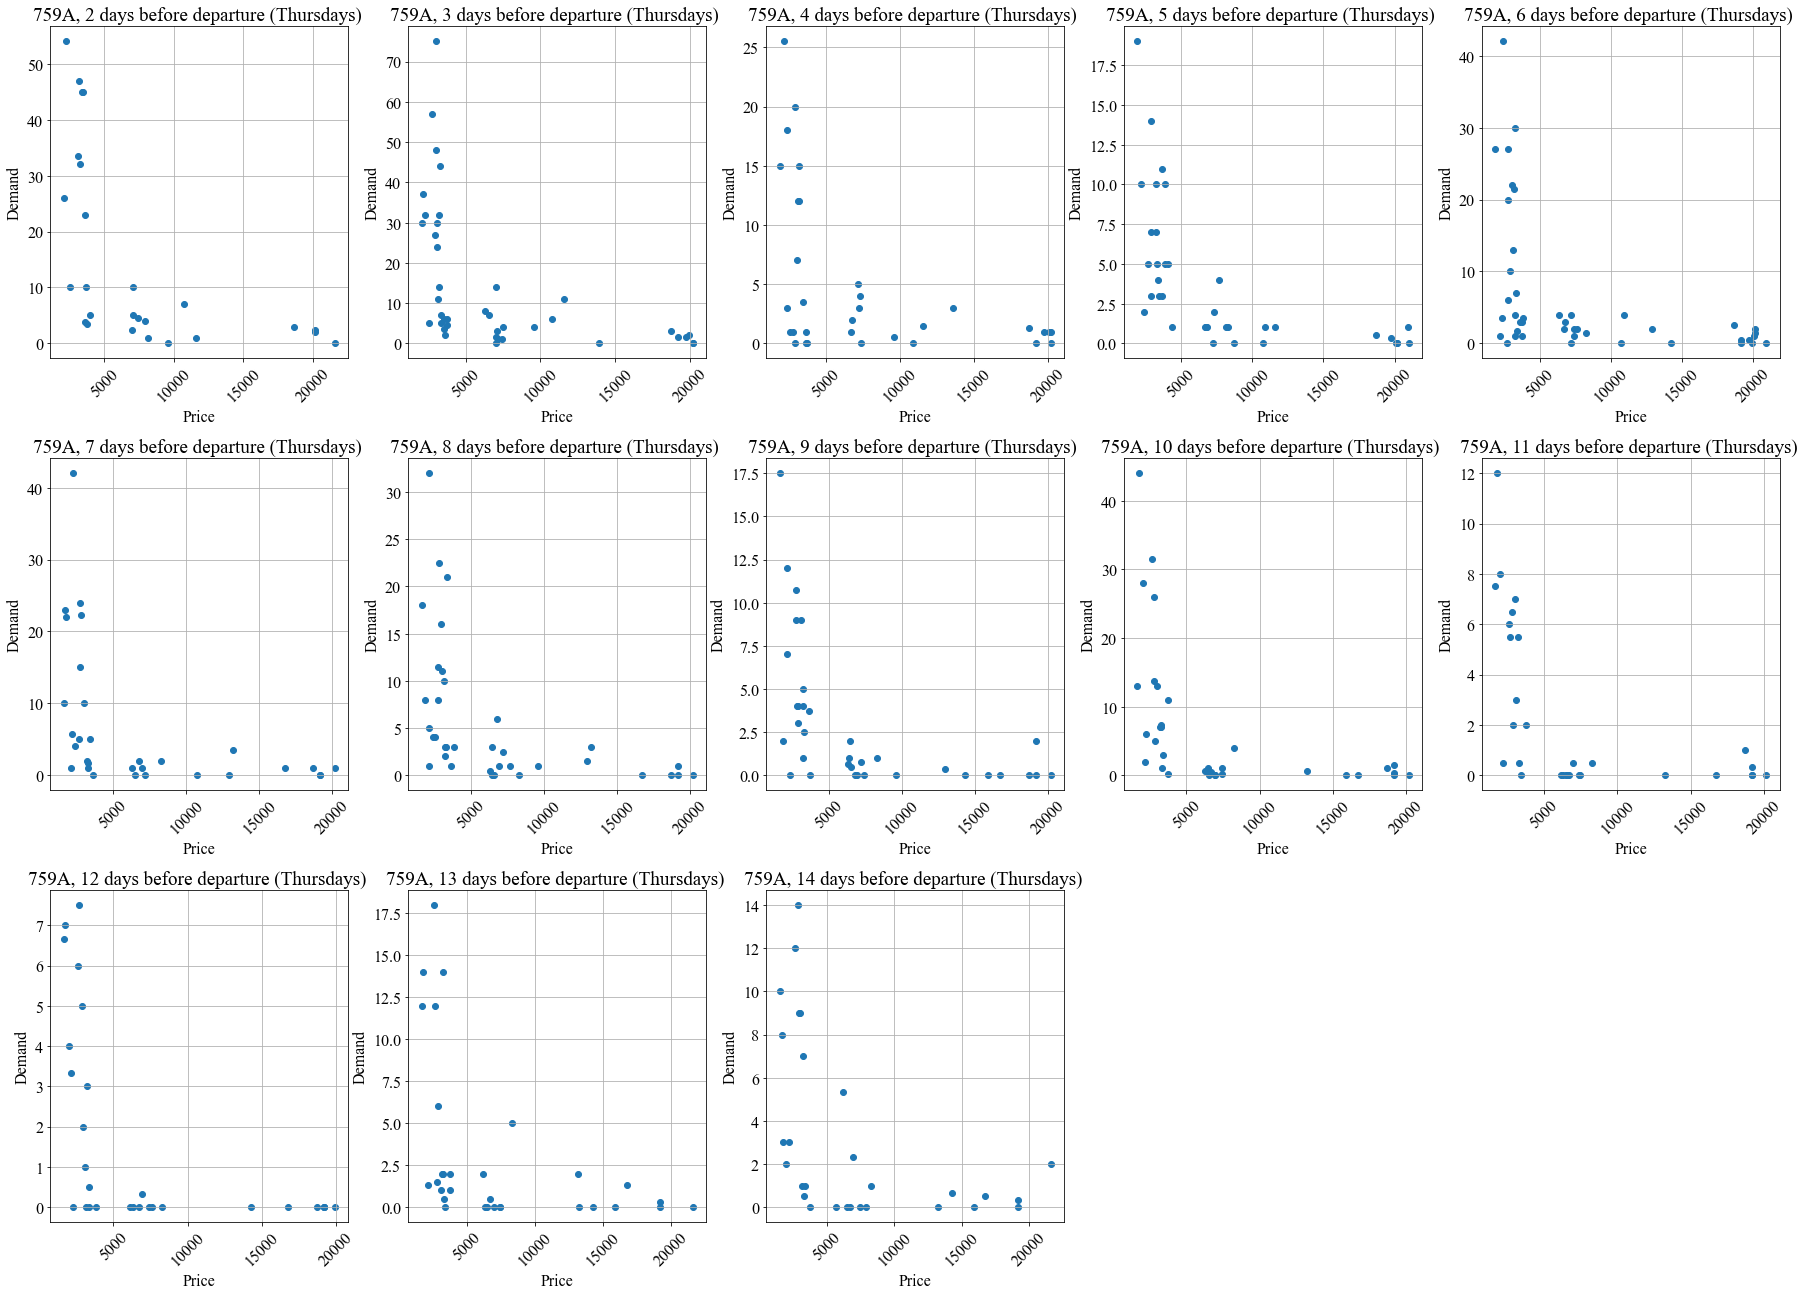

In [24]:
train_name='759А'
wk_day='Thursday'
scatter_plot(new_mean_p.loc[train_name].loc[wk_day], new_mean_d.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'mean')

### New Data linearization and Box Cox Transformation

In [20]:
new_log_lin_prices=pd.DataFrame(data=None, columns=new_prices.columns, index=new_prices.index, dtype="float")
new_lin_prices=pd.DataFrame(data=None, columns=new_prices.columns, index=new_prices.index, dtype="float")
new_log_shift_demand=pd.DataFrame(data=None, columns=new_demand.columns, index=new_demand.index, dtype="float")
new_shift_demand=pd.DataFrame(data=None, columns=new_demand.columns, index=new_demand.index, dtype="float")

new_list_ind=list(zip(sorted(np.array([new_uniq_train_num]*len(new_wk_days_mask)).ravel()), \
                  (new_wk_days_mask)*len(new_uniq_train_num)))
new_mu_ind=pd.MultiIndex.from_tuples(new_list_ind, names=("num", "day_name"))
new_min_df=pd.DataFrame(data=None, columns=new_prices.columns, index=new_mu_ind, dtype="float")

for num in new_uniq_train_num:
    new_uniq_wk_days=new_mean_p.loc[num].index.get_level_values('day_name').unique()
    for wk_day in new_uniq_wk_days:
        new_lin_data, new_log_lin_data, new_min_data, new_shift_labels, new_log_shift_labels=linearize_vars(new_mean_p.loc[num].loc[wk_day], new_mean_d.loc[num].loc[wk_day])
        
        new_lin_prices.loc[num].loc[wk_day]=new_lin_data.values
        new_log_lin_prices.loc[num].loc[wk_day]=new_log_lin_data.values
        new_log_shift_demand.loc[num].loc[wk_day]=new_log_shift_labels.values
        new_shift_demand.loc[num].loc[wk_day]=new_shift_labels.values
        new_min_df.loc[num].loc[wk_day]=new_min_data

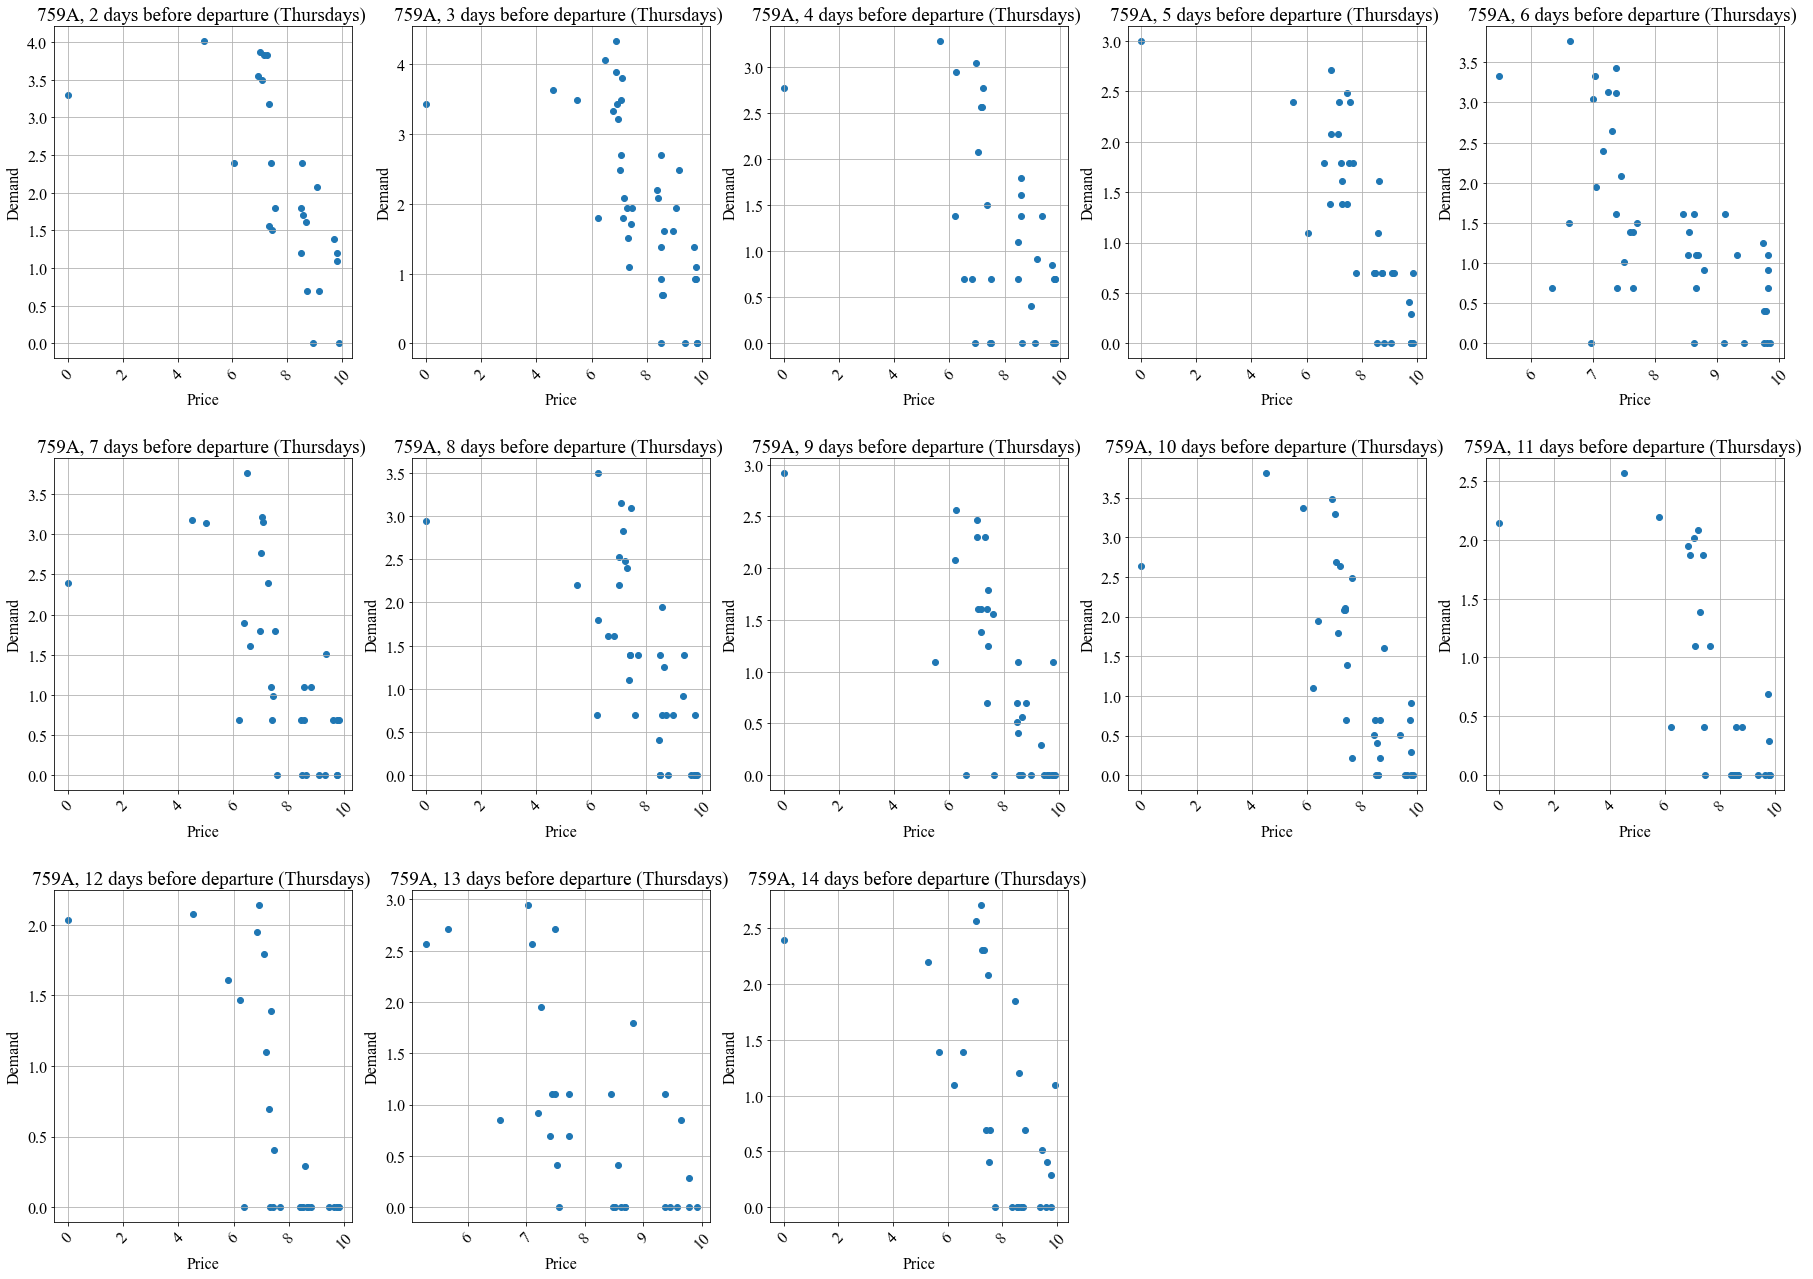

In [25]:
train_name='759А'
wk_day='Thursday'
scatter_plot(new_log_lin_prices.loc[train_name].loc[wk_day], new_log_shift_demand.loc[train_name].loc[wk_day], days, train_name+' '+wk_day+' '+'liner cleared')

### Ensemble of New Linear Regression Models

In [28]:
new_r2_df=pd.DataFrame(data=None, columns=new_prices.columns, index=new_mu_ind, dtype="float").sort_index()
new_pred_demand_df=pd.DataFrame(data=None, columns=new_demand.columns, index=new_demand.index, dtype="float").sort_index()
new_relined_demand_df=pd.DataFrame(data=None, columns=new_demand.columns, index=new_demand.index, dtype="float").sort_index()
new_model_df=pd.DataFrame(data=None, columns=new_prices.columns, index=new_mu_ind).sort_index()
new_A_df=pd.DataFrame(data=None, columns=new_prices.columns, index=new_demand.index, dtype="float").sort_index()
new_B_df=pd.DataFrame(data=None, columns=new_prices.columns, index=new_demand.index, dtype="float").sort_index()
for num in new_uniq_train_num:
    for wk_day in new_wk_days_mask:
        for day in new_log_lin_prices.columns:
            if not((len(new_log_lin_prices.loc[num].loc[wk_day][day].dropna())==0) | (len(new_log_shift_demand.loc[num].loc[wk_day][day].dropna())==0)):
                
                new_mask=~np.isnan(new_log_shift_demand.loc[num].loc[wk_day][day].astype(np.float64))
                
                new_r2, new_demand_pred, new_line_reg=validation_model(new_log_lin_prices.loc[num].loc[wk_day][day][new_mask], new_log_shift_demand.loc[num].loc[wk_day][day][new_mask])
                
                new_r2_df.loc[num].loc[wk_day][day]=new_r2
                
                new_pred_demand_df.loc[num].loc[wk_day][day][new_mask]=new_demand_pred
                new_relined_demand_df.loc[num].loc[wk_day][day][new_mask]=np.exp(new_demand_pred)-1
            
                new_model_df.loc[num].loc[wk_day][day]=new_line_reg
            
                new_A_df.loc[num, wk_day].T.loc[day]=new_line_reg.intercept_
                new_B_df.loc[num, wk_day].T.loc[day]=new_line_reg.coef_[0]

In [29]:
new_r2_df.to_csv('new_r2_df.csv')
new_pred_demand_df.to_csv('new_pred_demand_df.csv')

new_relined_demand_df.to_csv('new_relined_demand_df.csv')
new_model_df.to_csv('new_model_df.csv')

new_A_df.to_csv('new_A_df.csv')
new_B_df.to_csv('new_B_df.csv')

In [30]:
new_r2_df = pd.read_csv('new_r2_df.csv', index_col=[0, 1])
new_r2_df.columns.name='days'
new_r2_df.columns=new_r2_df.columns.astype(int)

new_pred_demand_df = pd.read_csv('new_pred_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_pred_demand_df.columns.name='days'
new_pred_demand_df.columns=new_pred_demand_df.columns.astype(int)

new_relined_demand_df = pd.read_csv('new_relined_demand_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_relined_demand_df.columns.name='days'
new_relined_demand_df.columns=new_relined_demand_df.columns.astype(int)

new_model_df = pd.read_csv('new_model_df.csv', index_col=[0, 1])
new_model_df.columns.name='days'
new_model_df.columns=new_model_df.columns.astype(int)

new_A_df = pd.read_csv('new_A_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_A_df.columns.name='days'
new_A_df.columns=new_A_df.columns.astype(int)

new_B_df = pd.read_csv('new_B_df.csv', index_col=[0, 1, 2, 3], parse_dates=[2])
new_B_df.columns.name='days'
new_B_df.columns=B_df.columns.astype(int)

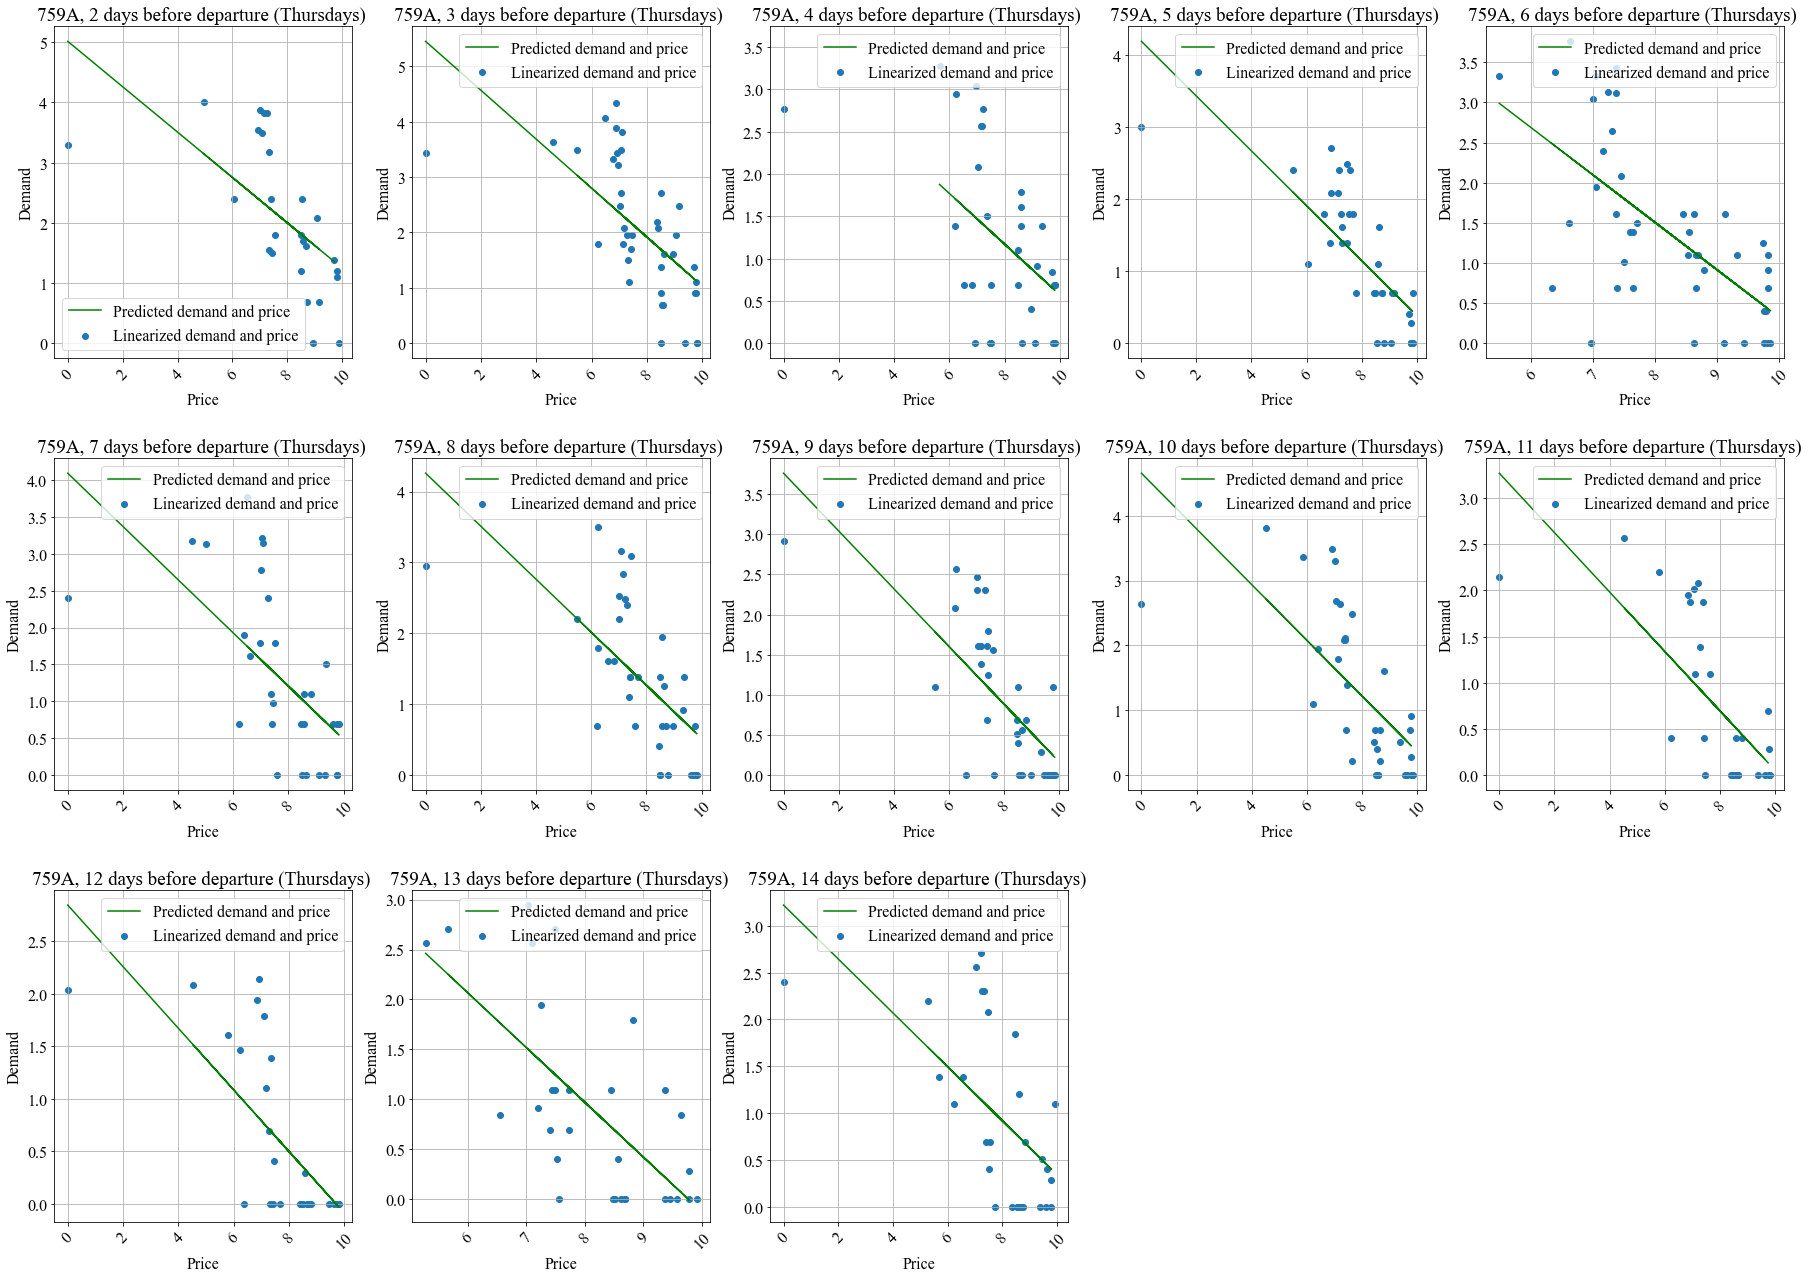

In [33]:
days=np.arange(2, 15)
train_name='759А'
wk_day='Thursday'
predicted_scatter_plot(new_log_lin_prices.loc[train_name].loc[wk_day], new_log_shift_demand.loc[train_name].loc[wk_day], 
                       new_pred_demand_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'predicted cleared')

In [51]:
new_exp_A_df=pd.DataFrame(data=np.exp(np.float64(new_A_df)), columns=new_A_df.columns, index=new_A_df.index, dtype="float")
new_relined_dem_df=new_exp_A_df*np.power(new_mean_p-new_min_df+1., new_B_df)-1.

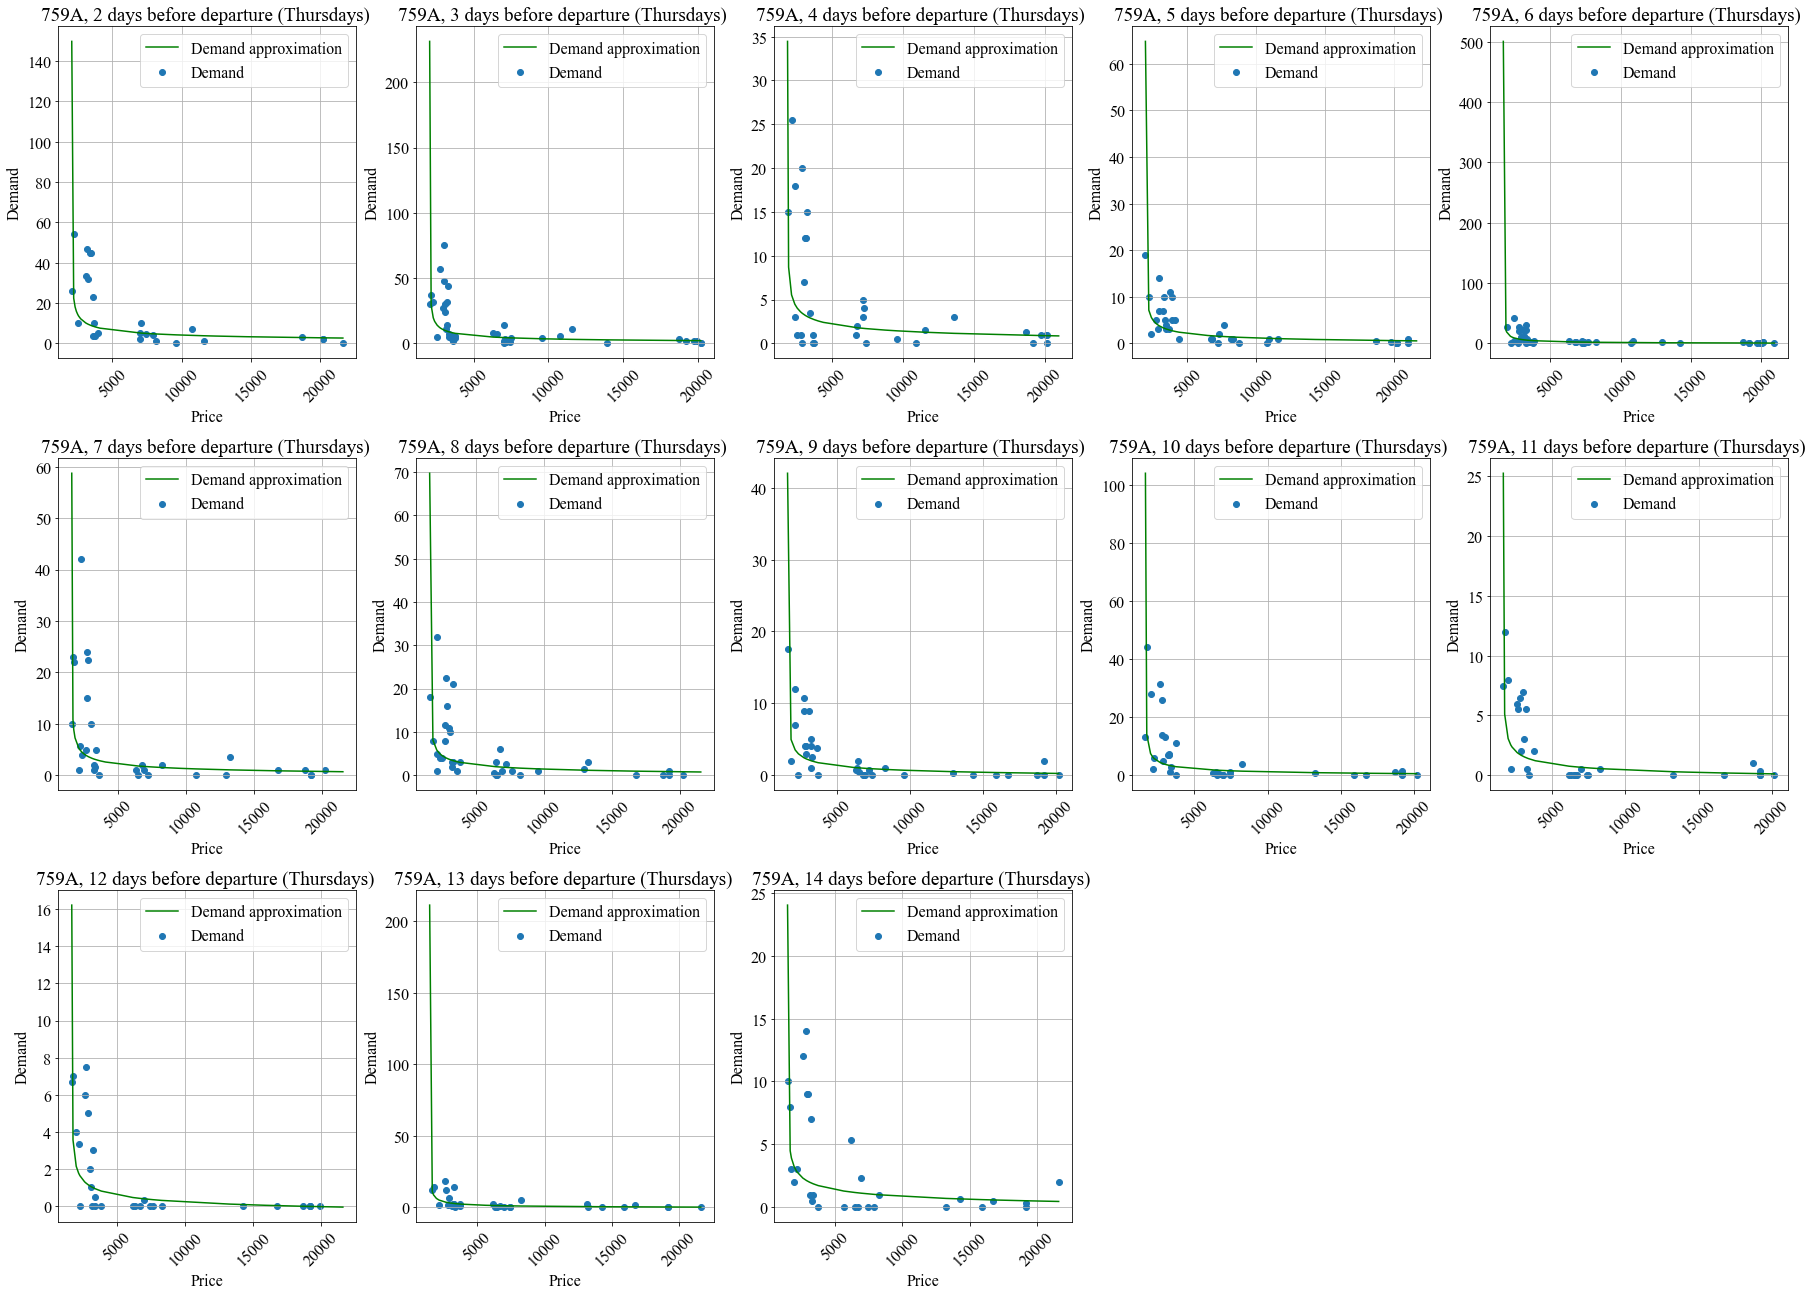

In [35]:
days=np.arange(2, 15)
train_name='759А'
wk_day='Thursday'
predicted_relined_scatter_plot(new_mean_p.loc[train_name].loc[wk_day], new_mean_d.loc[train_name].loc[wk_day], 
                       new_relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'predicted relined cleared')

### Residuals of the new models

In [52]:
new_epsilon=new_mean_d-new_relined_dem_df
new_epsilon=new_epsilon.mask(np.isinf(new_epsilon)).fillna(np.nan)
new_relativ_epsilon=new_epsilon/new_relined_dem_df 
new_relativ_epsilon=new_relativ_epsilon.mask(np.isinf(new_relativ_epsilon)).fillna(np.nan)
new_abs_eps=np.abs(new_epsilon)

In [ ]:
days=np.arange(2, 15)
train_name='759А'
wk_day='Thursday'
eps_hists(new_relativ_epsilon.loc[train_name].loc[wk_day, :14], days, train_name+' '+wk_day+' '+'gr rel_eps cleared')

### Incremental learning algorithm

In [38]:
def incremental_learn(A: list, B: list)->list:
    
    A_list=A.copy()
    B_list=B.copy()
    x=np.linspace(0, 1000)
    X=np.concatenate((x, x))
    
    while len(A_list)>1:

        f=[A_list.pop(0)+B_list.pop(0)*x, A_list.pop(0)+B_list.pop(0)*x]
        Y=np.concatenate((f[0], f[1]))
        line_reg = LinearRegression().fit(X.reshape(-1, 1), Y)
        Y_pred = line_reg.predict(X.reshape(-1, 1))
        a=line_reg.intercept_
        b=line_reg.coef_[0]
        A_list.insert(0, a)
        B_list.insert(0, b)
        
    return A_list, B_list

In [39]:
inc_exp_A_df=new_mean_p.copy()
inc_B_df=new_mean_p.copy()
for num in new_uniq_train_num:
    inc_uniq_wk_days=new_log_lin_prices.loc[num].index.get_level_values('day_name').unique()
    for wk_day in inc_uniq_wk_days:
        for day in new_log_lin_prices.columns:
            try:
                A_list=list([A_df.loc[num].loc[wk_day][day][0], new_A_df.loc[num].loc[wk_day][day][0]])
                B_list=list([B_df.loc[num].loc[wk_day][day][0], new_B_df.loc[num].loc[wk_day][day][0]])
                A, B=incremental_learn(A_list, B_list)
                inc_exp_A_df.loc[num].loc[wk_day, day]=np.exp(np.float64(A[0]))
                inc_B_df.loc[num].loc[wk_day, day]=B[0]
            except:
                continue

In [56]:
inc_prepr_demand=pd.concat([mean_d, new_mean_d])
inc_prepr_prices=pd.concat([mean_p, new_mean_p])
inc_min_df=new_mean_p.loc[train_name].loc[wk_day].min(axis=0)
inc_rel_prices=new_mean_p-inc_min_df+1.
inc_rel_prices=inc_rel_prices.pow(inc_B_df)
inc_relined_dem_df=inc_exp_A_df.loc[train_name].loc[wk_day].iloc[1]*inc_rel_prices-1.

### Residuals of the incremental models

In [57]:
def comp_errors(prep_demand: pd.DataFrame, rel_demand: pd.DataFrame)->pd.DataFrame:
    epsilon=prep_demand-rel_demand
    epsilon=epsilon.mask(np.isinf(epsilon)).fillna(np.nan)

    relativ_epsilon=epsilon/rel_demand 
    relativ_epsilon=relativ_epsilon.mask(np.isinf(relativ_epsilon)).fillna(np.nan)

    abs_eps=np.abs(epsilon)
    return abs_eps, relativ_epsilon

inc_abs_eps, inc_relativ_epsilon=comp_errors(new_mean_d, inc_relined_dem_df)

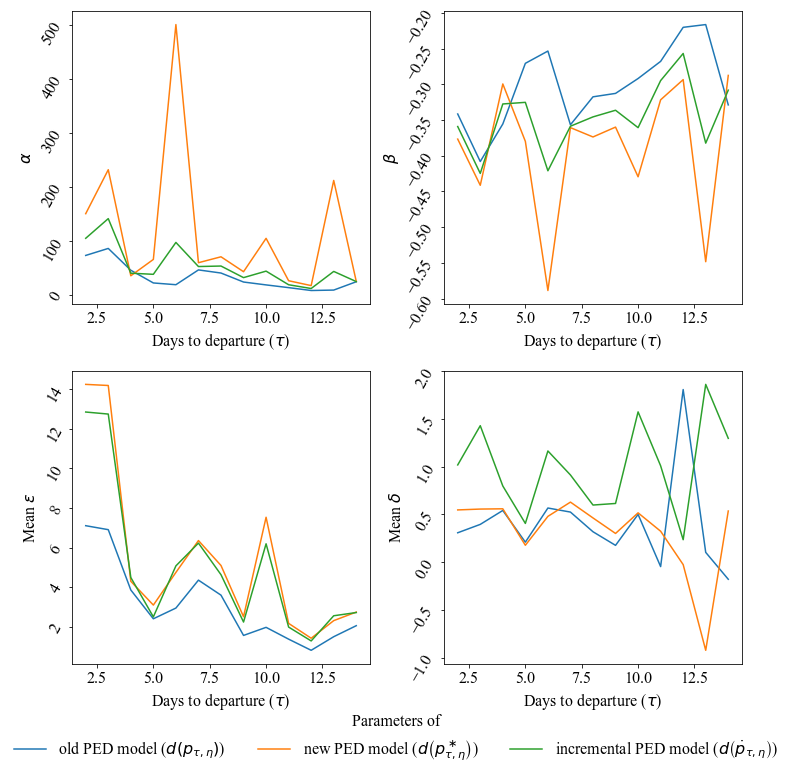

In [58]:
train_name='759А'
wk_day='Thursday'


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.23)

plot_inc_data_list=list([inc_exp_A_df.loc[train_name].loc[wk_day, :14].mean(axis=0), inc_B_df.loc[train_name].loc[wk_day, :14].mean(axis=0), 
                         inc_abs_eps.loc[train_name].loc[wk_day, :14].mean(axis=0), inc_relativ_epsilon.loc[train_name].loc[wk_day, :14].mean(axis=0)])
plot_data_list=list([new_exp_A_df.loc[train_name].loc[wk_day, :14].mean(axis=0), new_B_df.loc[train_name].loc[wk_day, :14].mean(axis=0), 
                     new_abs_eps.loc[train_name].loc[wk_day, :14].mean(axis=0), new_relativ_epsilon.loc[train_name].loc[wk_day, :14].mean(axis=0)])
plot_old_data_list=list([exp_A_df.loc[train_name].loc[wk_day, :14].mean(axis=0), B_df.loc[train_name].loc[wk_day, :14].mean(axis=0), 
                     abs_eps.loc[train_name].loc[wk_day, :14].mean(axis=0), relativ_epsilon.loc[train_name].loc[wk_day, :14].mean(axis=0)])

ylabels_list=list([r'$\alpha$', r'$\beta$', r'Mean $\epsilon$', 
                  r'Mean $\delta$'])
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for i, ax in enumerate(axes.flat):
    
    plot_old_data_list[i].plot(ax=ax)
    plot_data_list[i].plot(ax=ax)
    plot_inc_data_list[i].plot(ax=ax)

    ax.set_ylabel(ylabels_list[i])
    ax.set_xlabel(r'Days to departure ($\tau$)')
    ax.tick_params(axis='y', labelrotation=60)
        
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plt.figlegend([r'old PED model ($d\left(p_{\tau,\eta}\right)$)',
               r'new PED model ($d\left(p_{\tau,\eta}^\ast\right)$)', 
               r'incremental PED model ($d\left({\dot{p}}_{\tau,\eta}\right)$)'], 
              loc='lower center', ncol=3, frameon=False, borderaxespad=0.3, title='Parameters of')
#plt.savefig('Figure10_t'+'.pdf', transparent=True, bbox_inches='tight')
plt.show()

## Optimization

### Incremental price constrains

In [60]:
train_num='759А'
index=['B1', 'B2', 'C1', 'C2']
new_general_mean_pr_list=dict()
for i, cl in enumerate(index):
    new_general_mean_pr_list[cl]=np.array(pd.DataFrame(new_prices_cons.loc[train_num].groupby('class'))[1][i]).ravel()
new_general_mean_pr_list

{'B1': array([16068. , 14814. ,     nan, ...,     nan, 15913.8, 15913.8]),
 'B2': array([  nan, 3790., 3790., ...,   nan,   nan,   nan]),
 'C1': array([7097. , 6379. ,    nan, ...,    nan, 5862.7, 5862.7]),
 'C2': array([4301. , 3747. ,    nan, ...,    nan, 2459.6, 2459.6])}

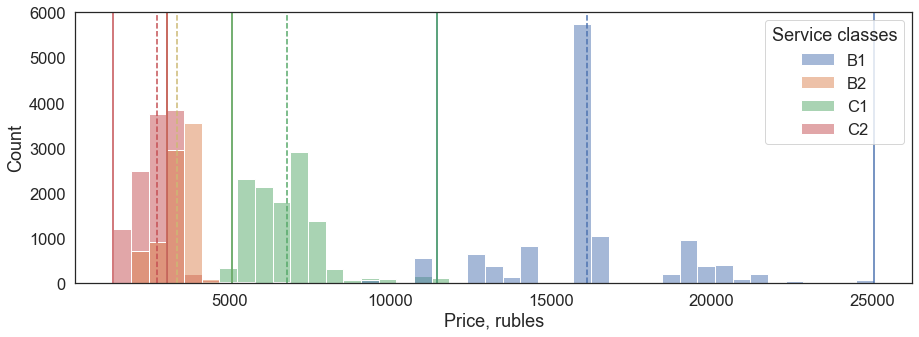

In [62]:
new_gmp_df=pd.DataFrame.from_dict(new_general_mean_pr_list, orient='index')
new_mean_val_prices_ser=new_gmp_df.mean(axis=1)
new_sorted_mvp_ser=new_mean_val_prices_ser.sort_values(ascending=False)
new_price_cons=(new_sorted_mvp_ser.shift()-new_sorted_mvp_ser)/2
new_max_price_cons=(new_mean_val_prices_ser+new_price_cons).fillna(new_gmp_df.loc['B1'].max())
new_min_price_cons=(new_max_price_cons.sort_values(ascending=True).shift().fillna(new_gmp_df.loc['C2'].min())-1).sort_index()
colors=['b', 'y', 'g', 'r']
sns.set(rc={'figure.figsize':(15,5)}, style="white", font_scale=1.5)
g=sns.histplot(new_gmp_df.T)
plt.xlabel('Price, rubles')
leg = g.axes.get_legend()
new_title = 'Service classes'
leg.set_title(new_title)
for i, j in enumerate(index):
    plt.axvline(new_mean_val_prices_ser.loc[j], color=colors[i], linestyle='--')
    plt.axvline(new_max_price_cons.loc[j], color=colors[i])
    plt.axvline(new_min_price_cons.loc[j], color=colors[i])
# plt.savefig('Prices_hist'+'.png', transparent=True, bbox_inches='tight')

### Monte Carlo incremental model validation

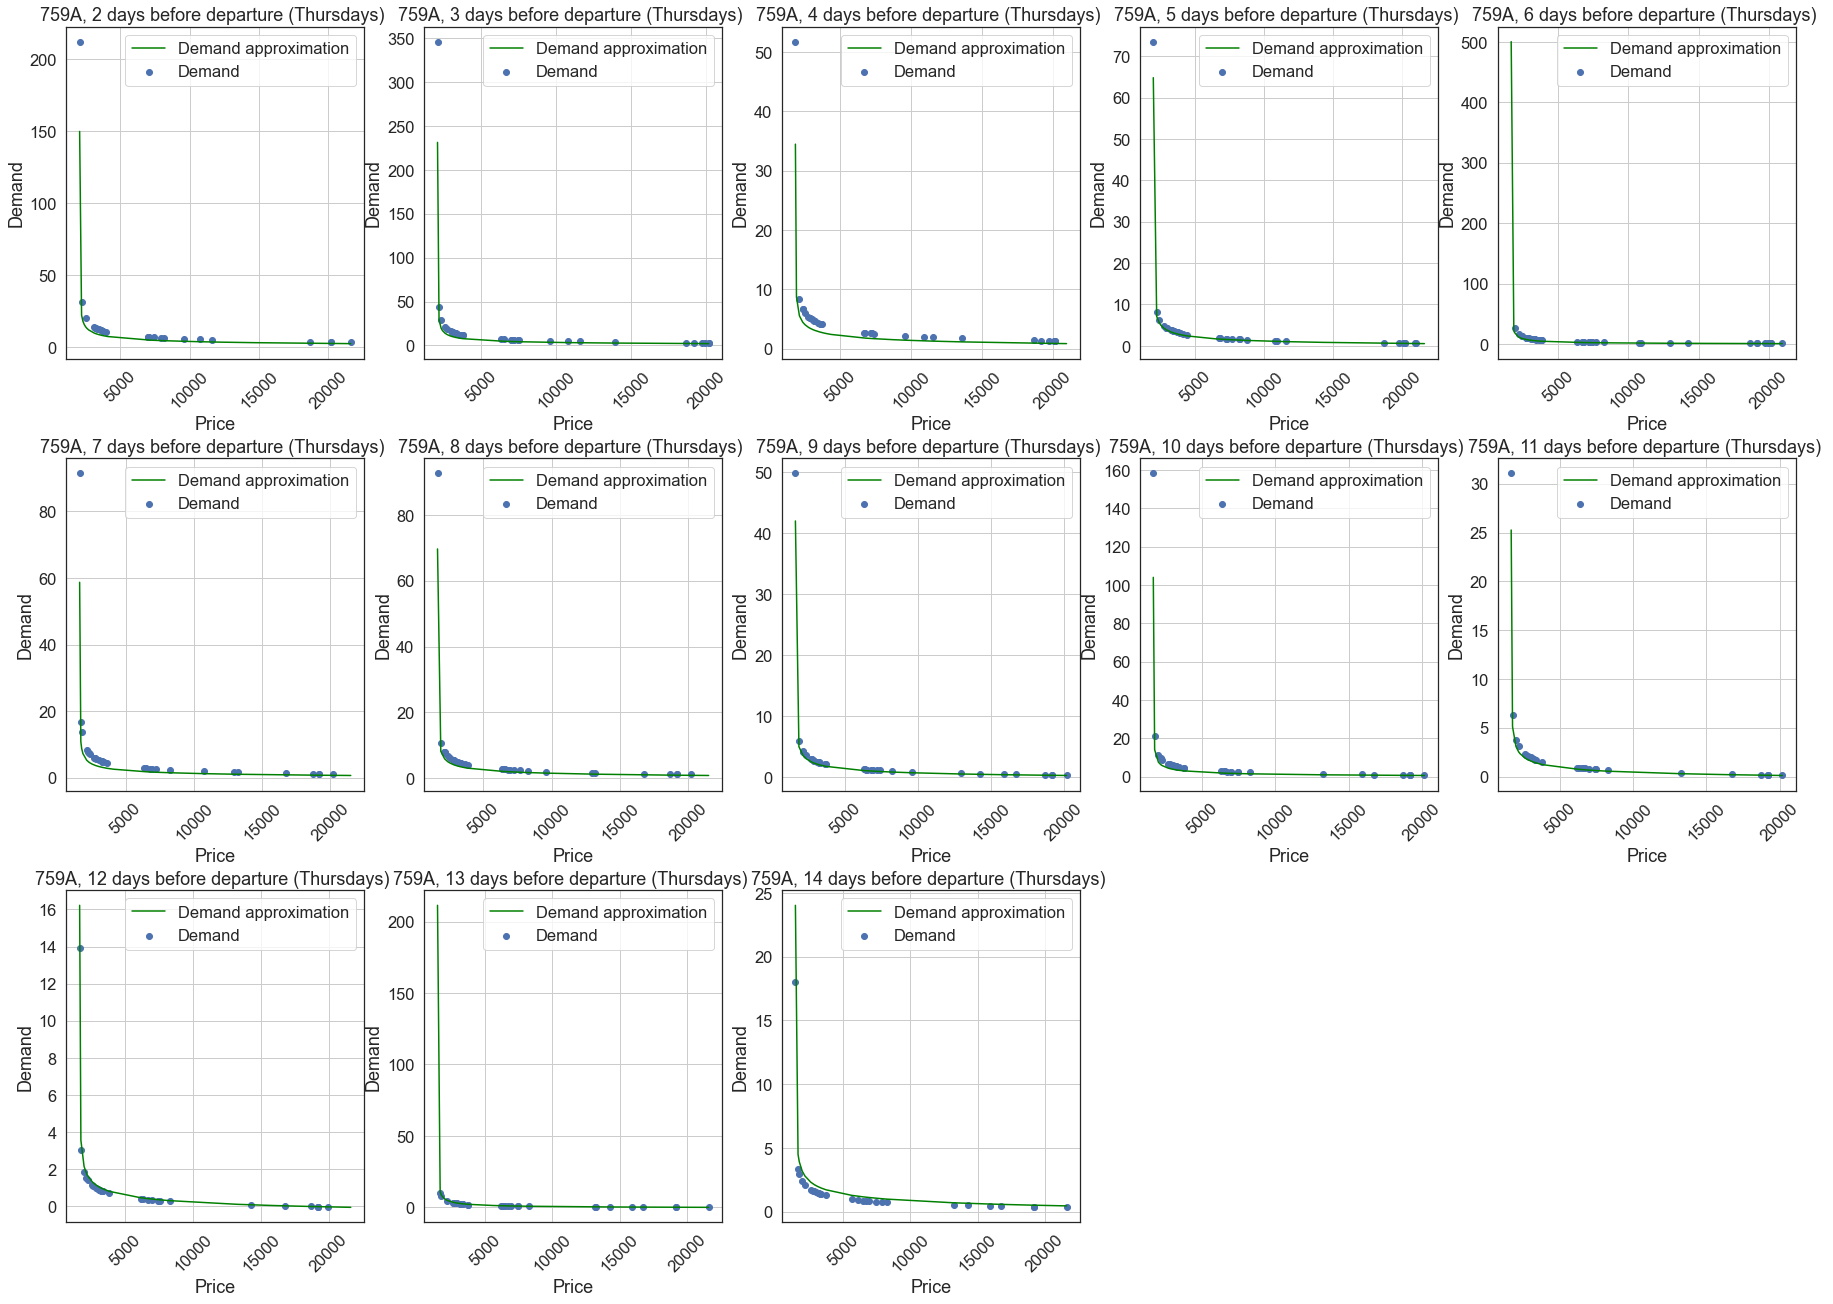

In [65]:
train_names=list(['759А'])
train_name='759А'
wk_days=list(['Thursday'])
wk_day='Thursday'
days_to_dept=13
num_classes=len(new_prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)
new_min_p=np.tile(np.array(new_min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0])
new_B=np.tile(np.array(new_B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
new_A=np.tile(np.array(new_exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
new_val_prices=new_mean_p.loc[train_name].loc[wk_day, :14][~np.isnan(new_mean_d.loc[train_name].loc[wk_day, :14])]
new_val_demand=new_mean_d.loc[train_name].loc[wk_day, :14][~np.isnan(new_mean_p.loc[train_name].loc[wk_day, :14])]
new_val_list=list()
for i in range(100):
    new_val_eps=list()
    for k in range(4):
        for day in range(2, days_to_dept+2):
            new_rel_eps_arr=np.array(new_relativ_epsilon.loc[train_name].loc[wk_day, day])
            new_rel_eps_arr=new_rel_eps_arr[~np.isnan(new_rel_eps_arr)]
            new_val_eps.append(EmpiricalDistribution(new_rel_eps_arr).rvs(1))
        new_val_eps=np.array(new_val_eps).ravel()
        new_relined_val_dem_df=(new_exp_A_df.loc[train_name].loc[wk_day, :14]*np.power(new_val_prices-new_min_df.loc[train_name].loc[wk_day, :14]+1., 
                                                                                       new_B_df.loc[train_name].loc[wk_day, :14])-1.)*(1+new_val_eps.T)
        new_val_list.append(new_relined_val_dem_df.T.values)
        new_val_eps=list()
new_mean_val_list=np.mean(new_val_list, axis=0)
new_mean_val_df=new_relined_val_dem_df.copy()
for i in range(2, 14):
    new_mean_val_df[i]=new_mean_val_list[i-2]
predicted_relined_scatter_plot(new_mean_p.loc[train_name].loc[wk_day], new_mean_val_df, 
                       new_relined_dem_df.loc[train_name].loc[wk_day],  days, train_name+' '+wk_day+' '+'val_model')

### Optimization algorithm

In [71]:
train_names=list(['759А'])
wk_days=list(['Thursday'])
days_to_dept=13

main_dict=dict()
wk_days_dict=dict()
res_dict=dict()

class optim_fun:
    
    def __init__(self, A, min_p, B, eps, arg_shape):
        self.A=A
        self.min_p=min_p
        self.B=B
        self.eps=eps
        self.arg_shape=arg_shape
        
    def revenue(self, x):
        self.x=x
        rev = -1.*np.sum(self.x*((self.A*np.power(self.x-self.min_p+1., self.B)-1.)*(1.+self.eps))) #
        return rev
    
    def f_con(self, x):
        self.x=x
        res_con=np.sum(np.array(((self.A*np.power(self.x-self.min_p+1., self.B)-1.)*(1.+self.eps))).reshape(self.arg_shape), axis=1) #
        return res_con

for train_name in train_names:
    for wk_day in wk_days:
        
        num_classes=len(new_prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
        arg_shape=(num_classes, days_to_dept)
        
        min_df=mean_p.loc[train_name].loc[wk_day].min(axis=0)

        min_p1=np.tile(np.array(min_df[:arg_shape[1]]), arg_shape[0]).ravel()
        min_p2=np.tile(np.array(new_min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
        min_p=(min_p1+min_p2)/2

        B=np.tile(np.array(inc_B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
        A=np.tile(np.array(inc_exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0]) #

        class_names=np.sort(new_prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
        
        general_mean_pr_list=dict()

        for i, cl in enumerate(class_names):
            general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()

        gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
        mean_val_prices_ser=gmp_df.mean(axis=1)
        sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
        price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
        max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
        min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
        max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
        min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()

        min_price[min_price<min_p]=min_p[min_price<min_p]
        max_price[min_price>max_price]=min_price[min_price>max_price]

        bounds = Bounds(min_price, max_price, keep_feasible = False)

        max_con=np.array(new_places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
        min_con=np.ones(arg_shape[0])
        
        opt_prices=list()
        opt_eps=list()
        opt_rev=list()
        
        iterations=100
        i=iterations
        errors=0
            
        while i>0:
            
            try:
                eps=list()

                for k in range(4):
                    for day in range(2, days_to_dept+2):
                        rel_eps_arr=np.array(inc_relativ_epsilon.loc[train_name].loc[wk_day, day])
                        rel_eps_arr=rel_eps_arr[~np.isnan(rel_eps_arr)]
                        eps.append(EmpiricalDistribution(rel_eps_arr).rvs(1))
                eps=np.array(eps).ravel()
                
                optim_f=optim_fun(A, min_p, B, eps, arg_shape)
                nlc = NonlinearConstraint(optim_f.f_con, min_con, max_con)
                
                min_res = differential_evolution(optim_f.revenue, bounds, constraints=(nlc), popsize=1)
                
                if min_res.success==False:
                    
                    go_to_except=1/0
                    
                opt_prices.append(min_res.x)
                opt_eps.append(eps)
                opt_rev.append(min_res.fun)
                
                i-=1
                errors=0
                
                clear_output(wait=True)
                print('Number of iterations: ', str(iterations-i))
                print('Found errors: ', str(errors))
                
            except:
                
                errors+=1
                
                clear_output(wait=True)
                print('Number of iterations: ', str(iterations-i))
                print('Found errors: ', str(errors))
                
                if errors>=100:
                    
                    break
                    
                else:
                    
                    continue
        
        res_dict['prices']=opt_prices
        res_dict['eps']=opt_eps
        res_dict['rev']=opt_rev
        
        wk_days_dict[wk_day]=res_dict
        main_dict[train_name]=wk_days_dict

Number of iterations:  100
Found errors:  0


### Validation of incremental optimization results. Estimation of optimal prices, demand and revenue.

In [74]:
train_num='759А'
day='Thursday'

opt_prices=main_dict[train_num][day]['prices']
opt_eps=main_dict[train_num][day]['eps']

mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev)

def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1., B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem

def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev

val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices, opt_eps):
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

mean_val_rev=-1*np.mean(val_rev_list)
mean_val_dem=np.mean(val_dem_list, axis=0)
print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))

rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()

print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

Mean validation revenue 1301185.9532983904
Mean validation demand [ 13.13081594  30.7799739   29.43115923 238.27426405]
Tickets [ 15.36842105  32.6875      38.05263158 239.10526316]
Optimal prices >= min prices? {True}
Optimal prices <= max prices? {True}
Revenue of Russian Railways 858370.8912698412
Revenue update, %: 51.587846993910226


In [75]:
with open(r'Inc_opt_data\inc_759A_Thursday_1.npy', 'wb') as f:
    np.save(f, np.array(opt_prices))
    np.save(f, np.array(opt_eps))
    np.save(f, np.array(opt_rev))

In [76]:
with open(r'Inc_opt_data\inc_759A_Thursday_1.npy', 'rb') as f:
    opt_prices_de_14 = np.load(f, allow_pickle=True)
    opt_eps_de_14 = np.load(f, allow_pickle=True)
    opt_rev_de_14 = np.load(f, allow_pickle=True)

In [77]:
train_names=list(['759А'])
train_num='759А'
wk_day=list(['Thursday'])
days_to_dept=13
day='Thursday'
num_classes=len(new_prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
arg_shape=(num_classes, days_to_dept)
min_p1=np.tile(np.array(min_df[:arg_shape[1]]), arg_shape[0]).ravel()
min_p2=np.tile(np.array(new_min_df.loc[train_name].loc[wk_day, :arg_shape[1]+1]), arg_shape[0]).ravel()
min_p=(min_p1+min_p2)/2
B=np.tile(np.array(inc_B_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0])
A=np.tile(np.array(inc_exp_A_df.loc[train_name].loc[wk_day, :arg_shape[1]+1].mean()), arg_shape[0]) #
class_names=np.sort(new_prices.loc[train_name].loc[wk_day].index.get_level_values('class').unique())
general_mean_pr_list=dict()
for i, cl in enumerate(class_names):
    general_mean_pr_list[cl]=np.array(pd.DataFrame(prices_cons.loc[train_name].groupby('class'))[1][i]).ravel()
gmp_df=pd.DataFrame.from_dict(general_mean_pr_list, orient='index')
mean_val_prices_ser=gmp_df.mean(axis=1)
sorted_mvp_ser=mean_val_prices_ser.sort_values(ascending=False)
price_cons=(sorted_mvp_ser.shift()-sorted_mvp_ser)/2
max_price=(mean_val_prices_ser+price_cons).fillna(gmp_df.loc[gmp_df.index[0]].max())
min_price=(max_price.sort_values(ascending=True).shift().fillna(gmp_df.loc[gmp_df.index[-1]].min())+1).sort_index()
max_price=np.tile(max_price.values.reshape(-1,1), arg_shape[1]).ravel()
min_price=np.tile(min_price.values.reshape(-1,1), arg_shape[1]).ravel()
min_price[min_price<min_p]=min_p[min_price<min_p]
max_price[min_price>max_price]=min_price[min_price>max_price]
max_con=np.array(new_places.loc[train_name].loc[wk_day, arg_shape[1]+1].groupby('class').apply(np.nanmean))
min_con=np.ones(arg_shape[0])
opt_prices=opt_prices_de_14
opt_eps=opt_eps_de_14
mean_opt_pr = np.mean(opt_prices, axis=0).reshape(arg_shape)
mean_opt_rev = -1*np.mean(opt_rev_de_14)
def validate_demand(x, A, min_p, B, eps):
    dem = np.sum(np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps)).reshape(arg_shape), axis=1)
    return dem
def revenue(x, A, min_p, B, eps):
    rev = -1.*np.sum(x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps)))
    return rev
val_dem_list=list()
val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)
mean_val_rev=-1*np.mean(val_rev_list)
mean_val_dem=np.mean(val_dem_list, axis=0)
print('Mean validation revenue', mean_val_rev)
print('Mean validation demand', mean_val_dem)
print('Tickets', max_con)
print('Optimal prices >= min prices?', set(min_price<=mean_opt_pr.ravel()))
print('Optimal prices <= max prices?', set(max_price>=mean_opt_pr.ravel()))
rus_rel_rev=mean_d.loc[train_num].loc[day, :arg_shape[1]+1]*mean_p.loc[train_num].loc[day, :arg_shape[1]+1]
rus_rel_rev=np.sum(rus_rel_rev.groupby('class').mean()).sum()
print('Revenue of Russian Railways', rus_rel_rev)
print('Revenue update, %:', ((mean_val_rev-rus_rel_rev)/rus_rel_rev)*100)

Mean validation revenue 1301185.9532983904
Mean validation demand [ 13.13081594  30.7799739   29.43115923 238.27426405]
Tickets [ 15.36842105  32.6875      38.05263158 239.10526316]
Optimal prices >= min prices? {True}
Optimal prices <= max prices? {True}
Revenue of Russian Railways 858370.8912698412
Revenue update, %: 51.587846993910226


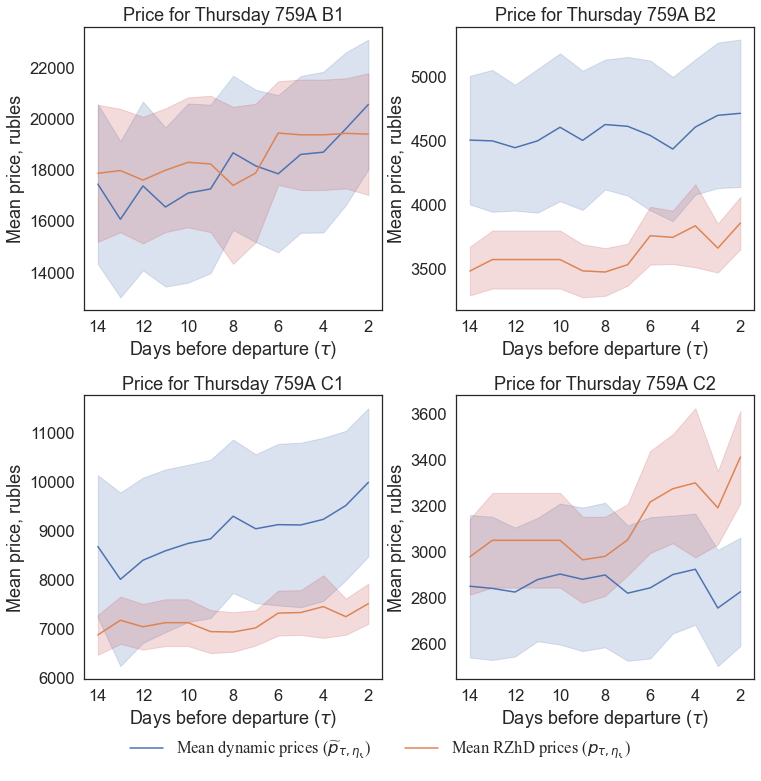

In [78]:
from matplotlib.ticker import MaxNLocator

ev_mean_pr=np.mean(opt_prices_de_14, axis=0).reshape(4, 13)
ev_std_pr=np.std(opt_prices_de_14, axis=0).reshape(4, 13)

pl_std=ev_mean_pr+ev_std_pr
mi_std=ev_mean_pr-ev_std_pr

rgd_mean_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_pr=np.array(mean_p.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std=rgd_mean_pr+rgd_std_pr
rgd_mi_std=rgd_mean_pr-rgd_std_pr


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_pr[cl])
    ax.fill_between(days_b_d, pl_std[cl], mi_std[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_pr[cl])
    ax.fill_between(days_b_d, rgd_pl_std[cl], rgd_mi_std[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean price, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Price for '+day+' '+train_num +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.figlegend([r'Mean dynamic prices (${\widetilde{p}}_{\tau,\eta,\k}$)',
               r'Mean RZhD prices ($p_{\tau,\eta,\k}$)'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name='Figure12_t_759A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

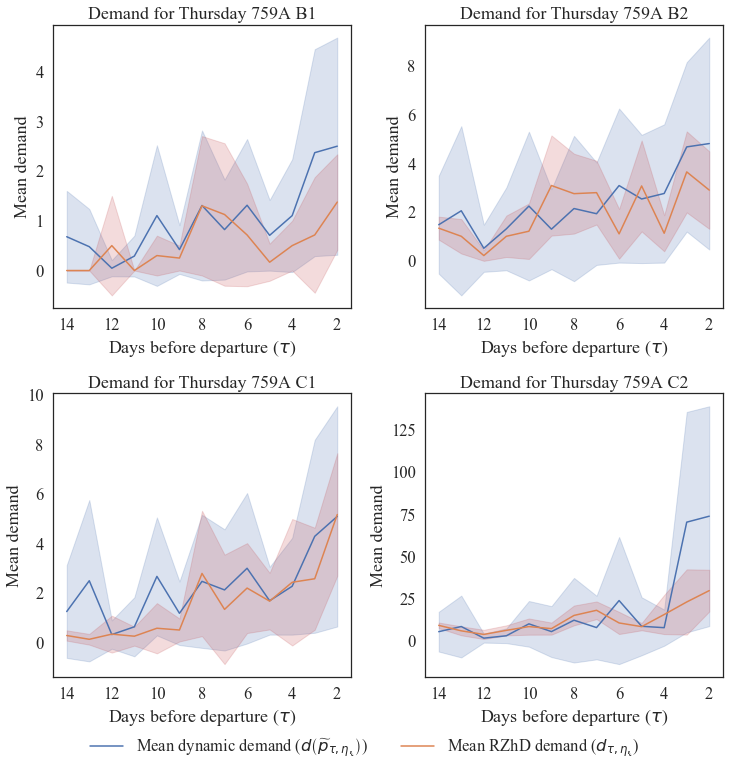

In [79]:
from matplotlib.ticker import MaxNLocator

def validate_demand(x, A, min_p, B, eps):
    dem = np.array((A*np.power(x-min_p+1, B)-1.)*(1.+eps))
    return dem

val_dem_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_dem=validate_demand(pr, A, min_p, B, ep)
    val_dem_list.append(val_dem)

ev_mean_dem=np.mean(val_dem_list, axis=0).reshape(4, 13)
ev_std_dem=np.std(val_dem_list, axis=0).reshape(4, 13)

pl_std_dem=ev_mean_dem+ev_std_dem
mi_std_dem=ev_mean_dem-ev_std_dem

rgd_mean_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanmean, axis=0))
rgd_std_dem=np.array(mean_d.loc[train_num].loc[day, :14].groupby('class').apply(np.nanstd, axis=0))

rgd_pl_std_dem=rgd_mean_dem+rgd_std_dem
rgd_mi_std_dem=rgd_mean_dem-rgd_std_dem


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.25, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)
cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_dem[cl])
    ax.fill_between(days_b_d, pl_std_dem[cl], mi_std_dem[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_dem[cl])
    ax.fill_between(days_b_d, rgd_pl_std_dem[cl], rgd_mi_std_dem[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean demand')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Demand for '+day+' '+train_num +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic demand ($d\left({\widetilde{p}}_{\tau,\eta,\k}\right)$)',
               r'Mean RZhD demand ($d_{\tau,\eta,\k}$)'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name='Figure13_t_759A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

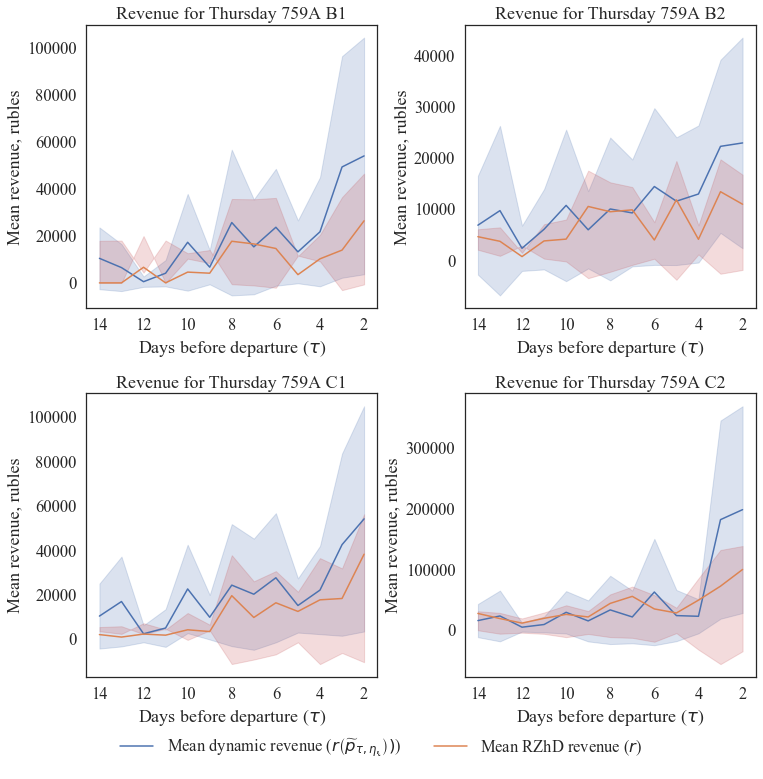

In [80]:
from matplotlib.ticker import MaxNLocator

def revenue(x, A, min_p, B, eps):
    rev = x*((A*np.power(x-min_p+1., B)-1.)*(1.+eps))
    return rev

val_rev_list=list()
for pr, ep in zip(opt_prices_de_14, opt_eps_de_14):
    
    val_rev=revenue(pr, A, min_p, B, ep)
    val_rev_list.append(val_rev)

ev_mean_rev=np.mean(val_rev_list, axis=0).reshape(4, 13)
ev_std_rev=np.std(val_rev_list, axis=0).reshape(4, 13)

pl_std_rev=ev_mean_rev+ev_std_rev
mi_std_rev=ev_mean_rev-ev_std_rev


rgd_mean_rev=mean_d.loc[train_num].loc[day, :14]*mean_p.loc[train_num].loc[day, :14]
rgd_std_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanstd, axis=0))
rgd_mean_rev=np.array(rgd_mean_rev.groupby('class').apply(np.nanmean, axis=0))


rgd_pl_std_rev=rgd_mean_rev+rgd_std_rev
rgd_mi_std_rev=rgd_mean_pr-rgd_std_rev


fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
classes=np.arange(4)
days_b_d=np.arange(2, 15)

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
for cl, ax in zip(classes, axes.flatten().flatten()):
    ax.plot(days_b_d, ev_mean_rev[cl])
    ax.fill_between(days_b_d, pl_std_rev[cl], mi_std_rev[cl], color='b', alpha=.2)
    ax.plot(days_b_d, rgd_mean_rev[cl])
    ax.fill_between(days_b_d, rgd_pl_std_rev[cl], rgd_mi_std_rev[cl], color='r', alpha=.2)
    ax.set_ylabel('Mean revenue, rubles')
    ax.set_xlabel(r'Days before departure ($\tau$)')
    ax.set_title('Revenue for '+day+' '+train_num +' '+ cl_name_list[cl])
    ax.invert_xaxis()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.figlegend([r'Mean dynamic revenue ($r\left({\widetilde{p}}_{\tau,\eta,\k}\right))$)',
               r'Mean RZhD revenue ($r$)'], 
              loc='lower center', ncol=2, frameon=False, borderaxespad=0.8)
fig_name='Figure14_t_759A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')

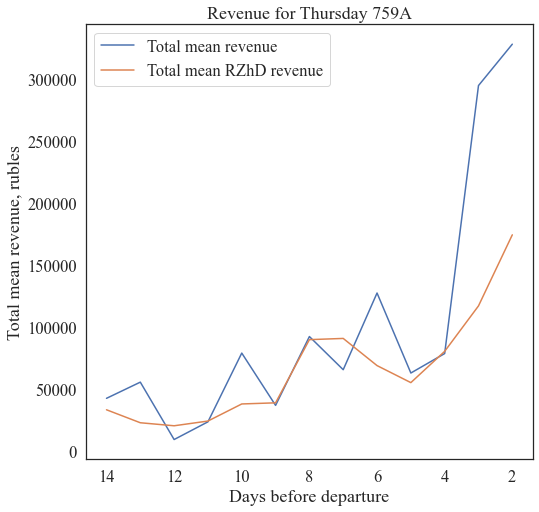

In [81]:
rgd_mean_rev=np.nansum(list(rgd_mean_rev), axis=0)
revv=np.nansum(list(ev_mean_rev), axis=0)
fig, ax = plt.subplots(1, figsize=(8, 8))

cl_name_list=['B1', 'B2', 'C1', 'C2']
plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
ax.plot(days_b_d, revv, label='Total mean revenue')
ax.plot(days_b_d, rgd_mean_rev, label='Total mean RZhD revenue')
ax.set_ylabel('Total mean revenue, rubles')
ax.set_xlabel('Days before departure')
ax.set_title('Revenue for '+day+' '+train_num)
ax.legend(loc='upper left')
ax.invert_xaxis()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

fig_name='Figure15_759A'
#plt.savefig(fig_name+'.pdf', transparent=True, bbox_inches='tight')